# Imports

In [1]:
# %pip install numpy
# %pip install opencv-python
# %pip install matplotlib

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import collections
from scipy.stats import linregress
import math
from PIL import Image, ImageTransform
from matplotlib import cm
from itertools import combinations
from enum import Enum

# Create objects

In [3]:
universal_pieces = []

In [4]:
class Pieces:
    piece_image_color = []
    piece_image_bw = []
    corners = []
    edges = []

In [5]:
class Edges:
    edge_image_color = []
    edge_image_bw = []
    shape = -1
    arr = []
    high = []
    low = []

In [6]:
class Shape(Enum):
    Hole = 0
    Head = 1
    Flat = 2

# Read Image

In [7]:
def show(img_input, name):
    plt.figure(figsize = (15,15))
    plt.axis("off")
    plt.title(name)
    plt.imshow(img_input)
    plt.show()

def show_multiple(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

def show_gray(img_input, name):
    plt.figure(figsize = (15,15))
    # plt.axis("off")
    plt.title(name)
    plt.imshow(img_input, cmap='gray')
    plt.show()

def show_multiple_gray(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i], cmap='gray')
    plt.tight_layout()
    plt.show()

def show_multiple_mix(img_input, names, gray):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        if(gray[i]):
            plt.imshow(img_input[i], cmap='gray')
        else:
            plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

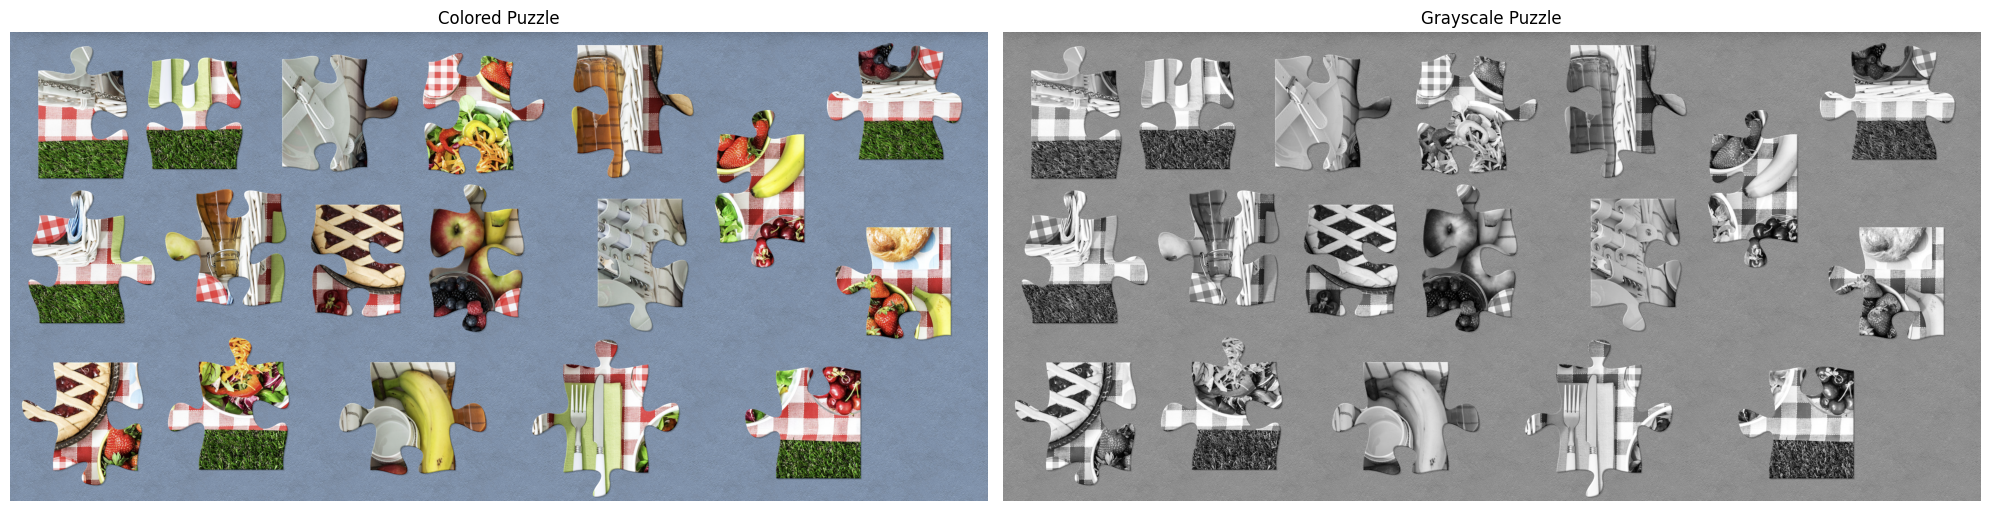

In [8]:

path = 'puzzle/picnic.png'
img_orig = cv2.imread(path, 1)
img_color = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

show_multiple_mix([img_color, gray], ["Colored Puzzle", "Grayscale Puzzle"], [False, True])

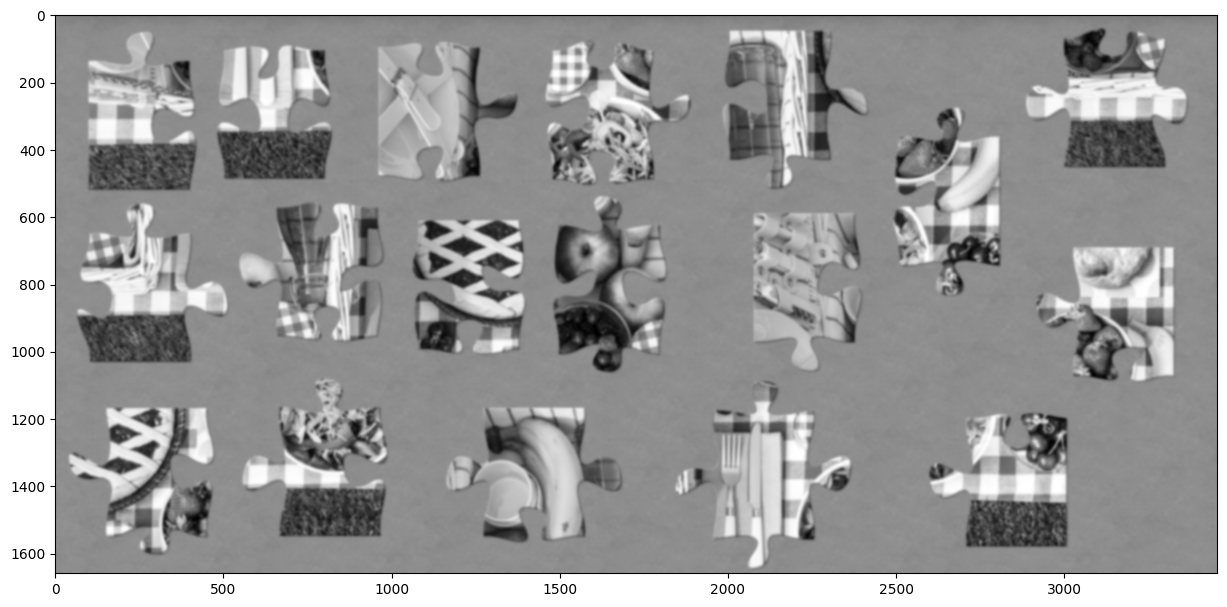

In [9]:
blurred = np.copy(gray)
blurred = cv2.GaussianBlur(blurred,(21,21),0)
show_gray(blurred,"")

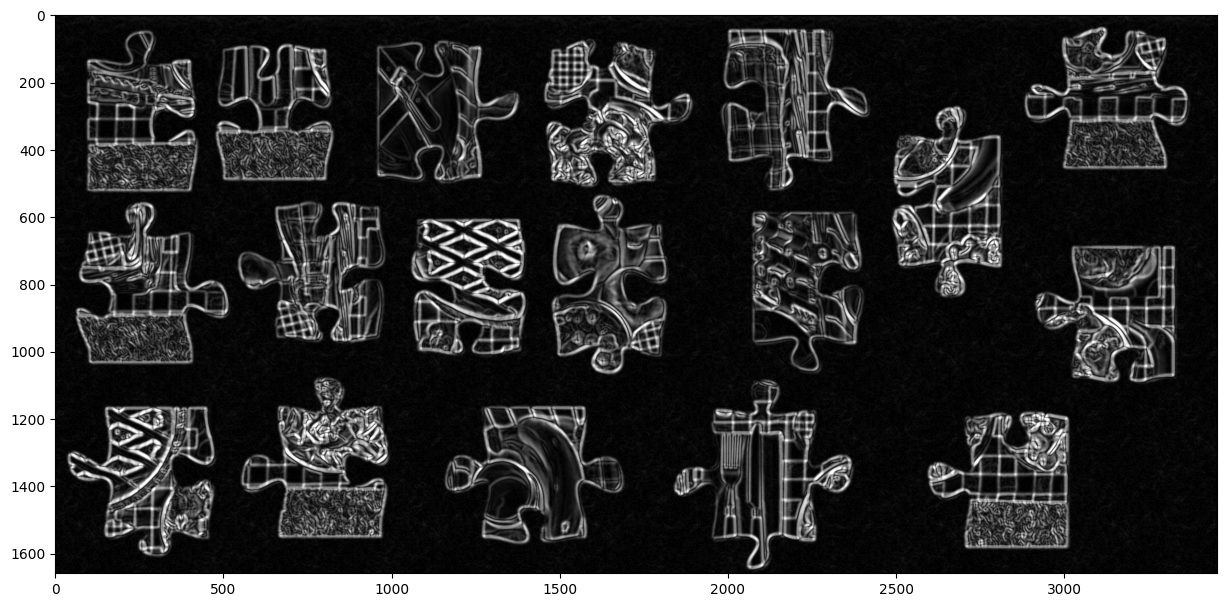

In [10]:
ksize = -1 # 3
gX = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
gY = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)
# the gradient magnitude images are now of the floating point data
# type, so we need to take care to convert them back a to unsigned
# 8-bit integer representation so other OpenCV functions can operate
# on them and visualize them
gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)
# combine the gradient representations into a single image
combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
show_gray(combined,"")

In [11]:
def do_overlap(l1, r1, l2, r2):
    # If one rectangle is on left side of other
    if l1[0] > r2[0] or l2[0] > r1[0]:
        return False
 
    # If one rectangle is above other
    if r1[1] < l2[1] or r2[1] < l1[1]:
        return False
 
    return True

[[1941, 1075, 441, 584], [51, 547, 478, 504], [1148, 1151, 554, 433], [1970, 32, 459, 503], [542, 1068, 462, 499], [2870, 28, 510, 445], [26, 1152, 460, 468], [1442, 67, 465, 457], [2477, 263, 350, 587], [1465, 525, 367, 555], [532, 545, 461, 441], [945, 68, 446, 445], [2582, 1168, 444, 430], [2901, 675, 441, 429], [83, 38, 353, 501], [2060, 575, 351, 493], [467, 77, 372, 430], [1047, 596, 363, 427], [1828, 1333, 125, 108]]


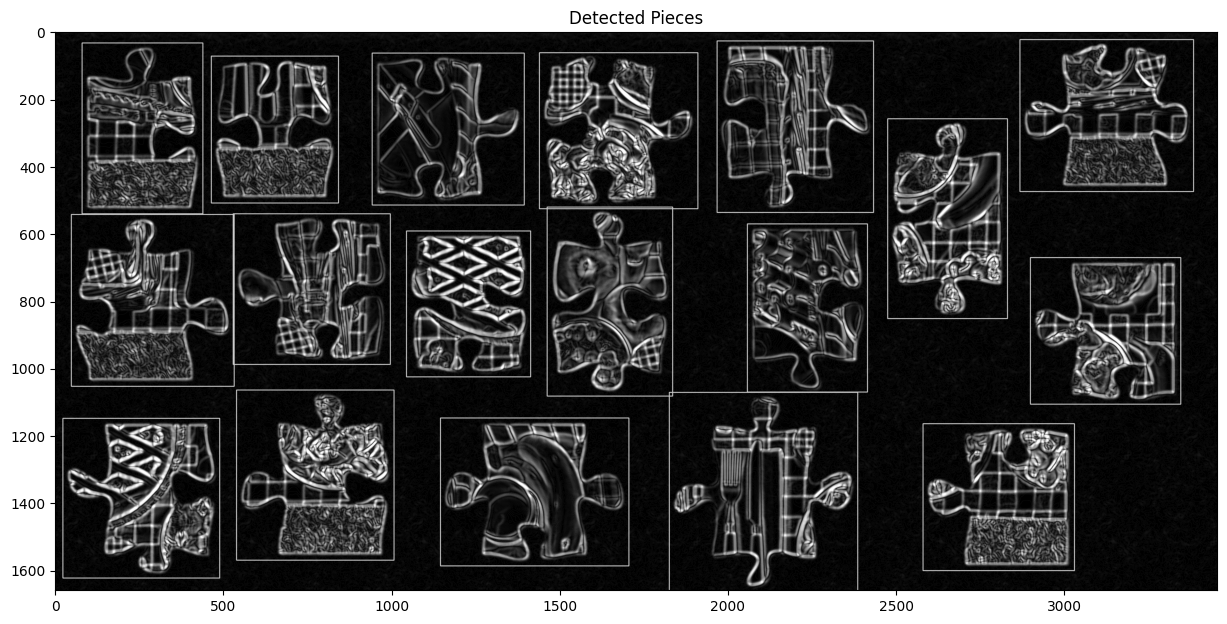

In [12]:
def detect_objects(image, image_color):
    pad =0
    universal_pieces.clear()
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,15)
    binary_image = cv2.bitwise_not(binary_image)
    # print(binary_image)

    # show_gray(binary_image,"")

    blur = cv2.GaussianBlur(image,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    mix = cv2.bitwise_or(th3, binary_image)

    # show_gray(th3, "")
    # show_gray(mix, "")
    
    kernel = np.ones((9, 9), np.uint8) 
    mix = cv2.dilate(mix, kernel, iterations=1)
    # mix = cv2.erode(mix, kernel, iterations=1)
    # mix = cv2.dilate(mix, kernel, iterations=1)
    # mix = cv2.erode(mix, kernel, iterations=1)

    # show_gray(mix, "")

    contours, _ = cv2.findContours(mix, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [list(cv2.boundingRect(x)) for x in contours]
    

    # Draw bounding boxes around each detected object
    img_with_boxes = np.copy(image)
    i=0
    while(i<len(contours)):
        contour = contours[i]
        x, y, w, h = contour
        if(w > 20 and h > 20):
            i=i+1
        else:
            del contours[i]

    # print(contours)
    i=0
    list1 = []
    while(i<len(contours)):
        contour = contours[i]
        x, y, w, h = contour
        list1.append(w*h)
        i=i+1
    
    list1, contours = zip(*sorted(zip(list1, contours)))
    contours = [list(x) for x in contours]
    contours.reverse()
    print(contours)
    i=0
    while(i<len(contours)):
        contour = contours[i]
        val = True
        x, y, w, h = contour
        xfinal = x
        yfinal = y
        x2final = w+x
        y2final = h+y
        j = i+1
        while(j<len(contours)):
            x2,y2,w2,h2 = contours[j]
            if(do_overlap([x,y],[w+x,h+y],[x2,y2],[w2+x2,h2+y2])):
                # val =False
                
                if(x2<xfinal):
                    xfinal = x2
                if(y2<yfinal):
                    yfinal = y2
                if(x2final<w2+x2):
                    x2final = w2+x2
                if(y2final<h2+y2):
                    y2final = h2+y2
                # print(contours[j])
                del contours[j]
                j=j-1
                
            j = j+1
        
        contours[i] = [xfinal, yfinal, x2final-xfinal, y2final-yfinal]
        x,y,w,h = contours[i]
        
        cv2.rectangle(img_with_boxes, (x-3, y-3), (x + w + 3, y + h + 3), (204, 204, 0), 2)
        puzzle_piece = Pieces()
        puzzle_piece.piece_image_bw = image[y-pad:y+h+pad, x-pad:x+w+pad]
        puzzle_piece.piece_image_bw = cv2.copyMakeBorder(puzzle_piece.piece_image_bw, 10,10,10,10,cv2.BORDER_CONSTANT, 0)
        puzzle_piece.piece_image_color = image_color[y-pad:y+h+pad, x-pad:x+w+pad]
        puzzle_piece.piece_image_color = cv2.copyMakeBorder(puzzle_piece.piece_image_color, 10,10,10,10,cv2.BORDER_REPLICATE, 0)
        universal_pieces.append(puzzle_piece)
        i=i+1
    return img_with_boxes

# Example usage: store pieces
image_pieces_detected = detect_objects(combined, img_color)

# Display the result
show_gray(image_pieces_detected, "Detected Pieces")

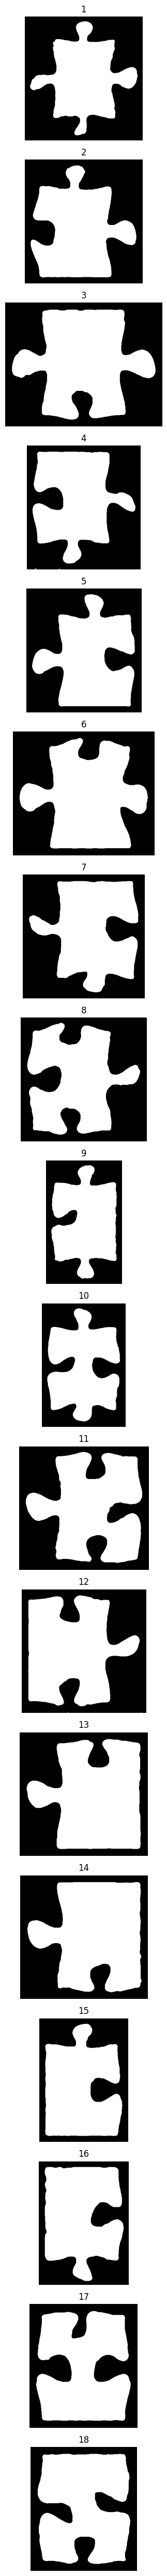

In [13]:
fig, axes = plt.subplots(nrows=len(universal_pieces), ncols=1, figsize=(150, 50))
# Iterate through the array and display each image
for i in range(len(universal_pieces)):
    image = np.copy((universal_pieces[i]).piece_image_color)
    image = cv2.GaussianBlur(image, (15,15),0)
    ksize = -1
    gX = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
    gY = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)

    gX = cv2.convertScaleAbs(gX)
    gY = cv2.convertScaleAbs(gY)
    # combine the gradient representations into a single image
    combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

    # image = cv2.medianBlur(combined, 15)
    image = cv2.GaussianBlur(combined, (25,25),0)
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # gX = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
    # gY = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)

    # gX = cv2.convertScaleAbs(gX)
    # gY = cv2.convertScaleAbs(gY)
    # # combine the gradient representations into a single image
    # combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

    # image = cv2.cvtColor(combined, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((3, 3), np.uint8) 
    # image = cv2.dilate(image, kernel, iterations=1)
    # image = cv2.erode(image, kernel, iterations=1)
    # image = cv2.dilate(image, kernel, iterations=1)
    # image = cv2.erode(image, kernel, iterations=1)
    # image = cv2.dilate(image, kernel, iterations=1)
    # image = cv2.erode(image, kernel, iterations=1)

    image = cv2.Canny(image,0,25)
    # image = connect_nearby(image, 2)
    (universal_pieces[i]).piece_image_bw = cv2.adaptiveThreshold((universal_pieces[i]).piece_image_bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,255,-15)
    image = cv2.bitwise_or(image, (universal_pieces[i]).piece_image_bw)
    # ret3,image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8) 
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.dilate(image, kernel, iterations=1)
    # print(image)

    im_floodfill = image.copy()
    im_floodfill = cv2.copyMakeBorder(im_floodfill, 1,0,0,0,cv2.BORDER_CONSTANT, 0)
    h, w = im_floodfill.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_floodfill_inv = im_floodfill_inv[1:]

    image = image | im_floodfill_inv

    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)


    # image = 
    
    # image = remove_background(image, 0.5)
    # image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,15)
    image = cv2.GaussianBlur(image, (21,21),0)
    ret3,image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    (universal_pieces[i]).piece_image_bw = image
    axes[i].imshow(image, cmap = 'gray')
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f"{i+1}")
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

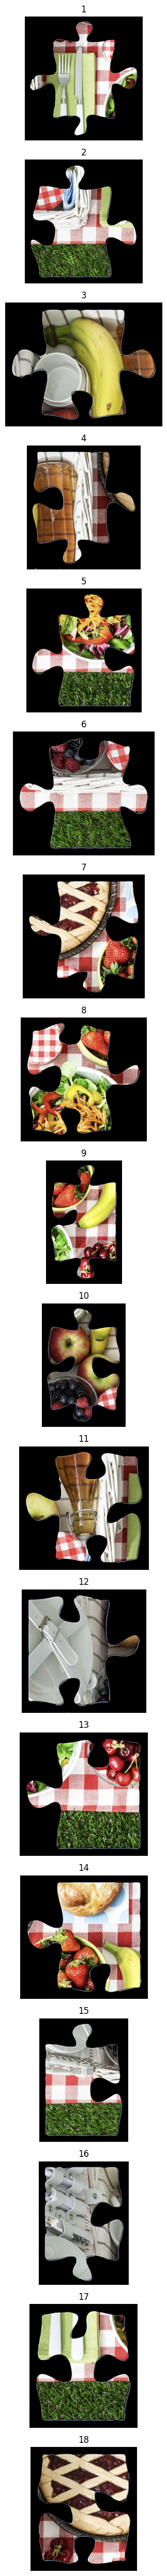

In [14]:
fig, axes = plt.subplots(nrows=len(universal_pieces), ncols=1, figsize=(150, 50))
# Iterate through the array and display each image
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_color
    mask = (universal_pieces[i]).piece_image_bw
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    # print(image.shape)
    # print(mask.shape)
    image = cv2.bitwise_and(image, mask)
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f"{i+1}")
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Find corners

In [15]:
def find_rmse(X,Y,m, c, n):
    rmse = 0
    for i in range(n):
        a = m
        b = -1
        d = abs((a * X[i] + b * Y[i] + c)) / (math.sqrt(a * a + b * b))
        rmse += d
        # y_pred = c + m * X[i]
        # rmse += (Y[i] - y_pred) ** 2
    rmse =(rmse/n)
    return rmse

In [16]:
def find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half):
    # slope1, yinter1= np.polyfit(array_line1_x, array_line1_y, 1)
    # slope2, yinter2= np.polyfit(array_line2_x, array_line2_y, 1)
    line1reg = linregress(array_line1_x, array_line1_y)
    line2reg = linregress(array_line2_x, array_line2_y)
    slope1 = line1reg.slope
    slope2 = line2reg.slope
    yinter1 = line1reg.intercept
    yinter2 = line2reg.intercept
    PI = 3.14159265
    taninv = abs((slope2 - slope1) / (1 + slope1 * slope2))
    ret = math.atan(taninv)
    angle = (ret * 180) / PI
    val=0
    if(angle>50 and angle<130):
        val = 150
    else:
        val =0
    rsme = find_rmse(array_line1_x, array_line1_y, slope1, yinter1, half) +find_rmse(array_line2_x, array_line2_y, slope2, yinter2, half)
    # rsme = line1reg.stderr + line2reg.stderr
    if(rsme>(5)):
        val = 0
    return val, rsme

In [17]:
def find_biggestsquare(list_elements):
    big_area=0
    arr=[]
    comb = combinations(list_elements, 4)
    for i, j, k, l in list(comb):
        first = i[0]*j[1] + j[0]*k[1] + k[0]*l[1] + l[0]*i[1]
        second = j[0]*i[1] + k[0]*j[1] + l[0]*k[1] + i[0]*l[1]
        area = 0.5*(first - second)
        area = abs(area)
        if(area>big_area):
            big_area = area
            arr.clear()
            arr.append(i)
            arr.append(j)
            arr.append(k)
            arr.append(l)
    
    return arr
                        

In [18]:
def add_elem(xval, yval,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half):
    array_line2_x[pointer_line2] = xval
    array_line2_y[pointer_line2] = yval
    pointer_line2 = (pointer_line2+1)%half
    array_line2_x[pointer_line2] = array_line2_x[pointer_line2]+0.001
    array_line1_x[pointer_line1] = array_line2_x[pointer_line2]
    array_line1_y[pointer_line1] = array_line2_y[pointer_line2]
    pointer_line1 = (pointer_line1+1)%half
    array_line1_x[pointer_line1] = array_line1_x[pointer_line1]+0.001
    return pointer_line1, pointer_line2

In [19]:
def find_corners(find_corner_image):
    completed = False
    pieces_drawbound = np.copy(find_corner_image)

    i=0
    j=0

    while(pieces_drawbound[i+1][j+1]!=255):
        i=i+1
        j=j+1

    # pieces_drawbound[i][j] = 200
    # show_gray(pieces_drawbound,"")
    
    size = len(pieces_drawbound)/2

    half = (int)((size+1)/2)
    array_line1_x = [0 for element in range(half)]
    array_line1_y = [0 for element in range(half)]
    pointer_line1 = 0
    array_line2_x = [1 for element in range(half)]
    array_line2_y = [1 for element in range(half)]
    pointer_line2 = 0

    list_elements = []

    direction =0 #0 is up, 1 is right, 2 is down and 3 is left
    move = [[-1,0],[0,1],[1,0],[0,-1]]
    initial_i = i
    initial_j = j
    counter = 0
    counter_add = 0
    while (not(completed) and counter<5000):
        counter= counter+1
        index = direction
        top_piece = pieces_drawbound[i+move[index%4][0]][j+move[index%4][1]]
        index = index +1
        right_piece = pieces_drawbound[i+move[index%4][0]][j+move[index%4][1]]
        if(right_piece==255):
            if(top_piece==255):
                direction = direction-1
            else:
                pointer_line1,pointer_line2 = add_elem(i,j,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half)
                counter_add = counter_add+1

                if(counter_add==(half-1)):
                    initial_i = i
                    initial_j = j
            
                
                if(counter_add>=size):
                    val, rsme = find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half)
                    if(val>0):
                        list_elements.append([int(array_line2_x[pointer_line2]),int(array_line2_y[pointer_line2]), rsme])
                    # pieces_drawbound[array_line2_x[pointer_line2]][array_line2_y[pointer_line2]] = val
                    if(int(array_line2_x[pointer_line2])==initial_i and int(array_line2_y[pointer_line2])==initial_j):
                        completed = True

                

                i = i+move[direction%4][0]
                j = j+move[direction%4][1]
        else:
            pointer_line1,pointer_line2 = add_elem(i,j,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half)
            
            counter_add = counter_add+1
        
            if(counter_add==(half-1)):
                initial_i = i
                initial_j = j

            if(counter_add>=size):
                val, rmse = find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half)
                if(val>0):
                    list_elements.append([int(array_line2_x[pointer_line2]),int(array_line2_y[pointer_line2]), rmse])
                # pieces_drawbound[array_line2_x[pointer_line2]][array_line2_y[pointer_line2]] = val
                if(int(array_line2_x[pointer_line2])==initial_i and int(array_line2_y[pointer_line2])==initial_j):
                    completed = True


            direction = direction+1
            i = i+move[direction%4][0]
            j = j+move[direction%4][1]
    # final = find_biggestsquare(list_elements)

    final_list = []
    local_min = list_elements[0][2]
    local_x = list_elements[0][0]
    local_y = list_elements[0][1]
    # final_list = list_elements
    for i in range(1,len(list_elements)):
        # print(list_elements[i])
        x = list_elements[i][0]
        y = list_elements[i][1]
        prev_x = list_elements[i-1][0]
        prev_y = list_elements[i-1][1]
        if((x>prev_x-2 and x<prev_x+2) and (y>prev_y-2 and y<prev_y+2)):
            if(list_elements[i][2]<local_min):
                local_min = list_elements[i][2]
                local_x = x
                local_y = y
        else:
            final_list.append([local_x, local_y, local_min])
            # print("hi")
            local_min = list_elements[i][2]
            local_x = x
            local_y = y
    final_list.append([local_x, local_y, local_min])

    final = find_biggestsquare(final_list)

    for i in final:
        cv2.circle(pieces_drawbound, (int(i[1]) , int(i[0])), 2, (200),2)
        # pieces_drawbound[int(i[0])][int(i[1])]=150


    # for i in final:
        # pieces_drawbound[i[0]][i[1]]=150
    return pieces_drawbound, [(i[0], i[1]) for i in final]


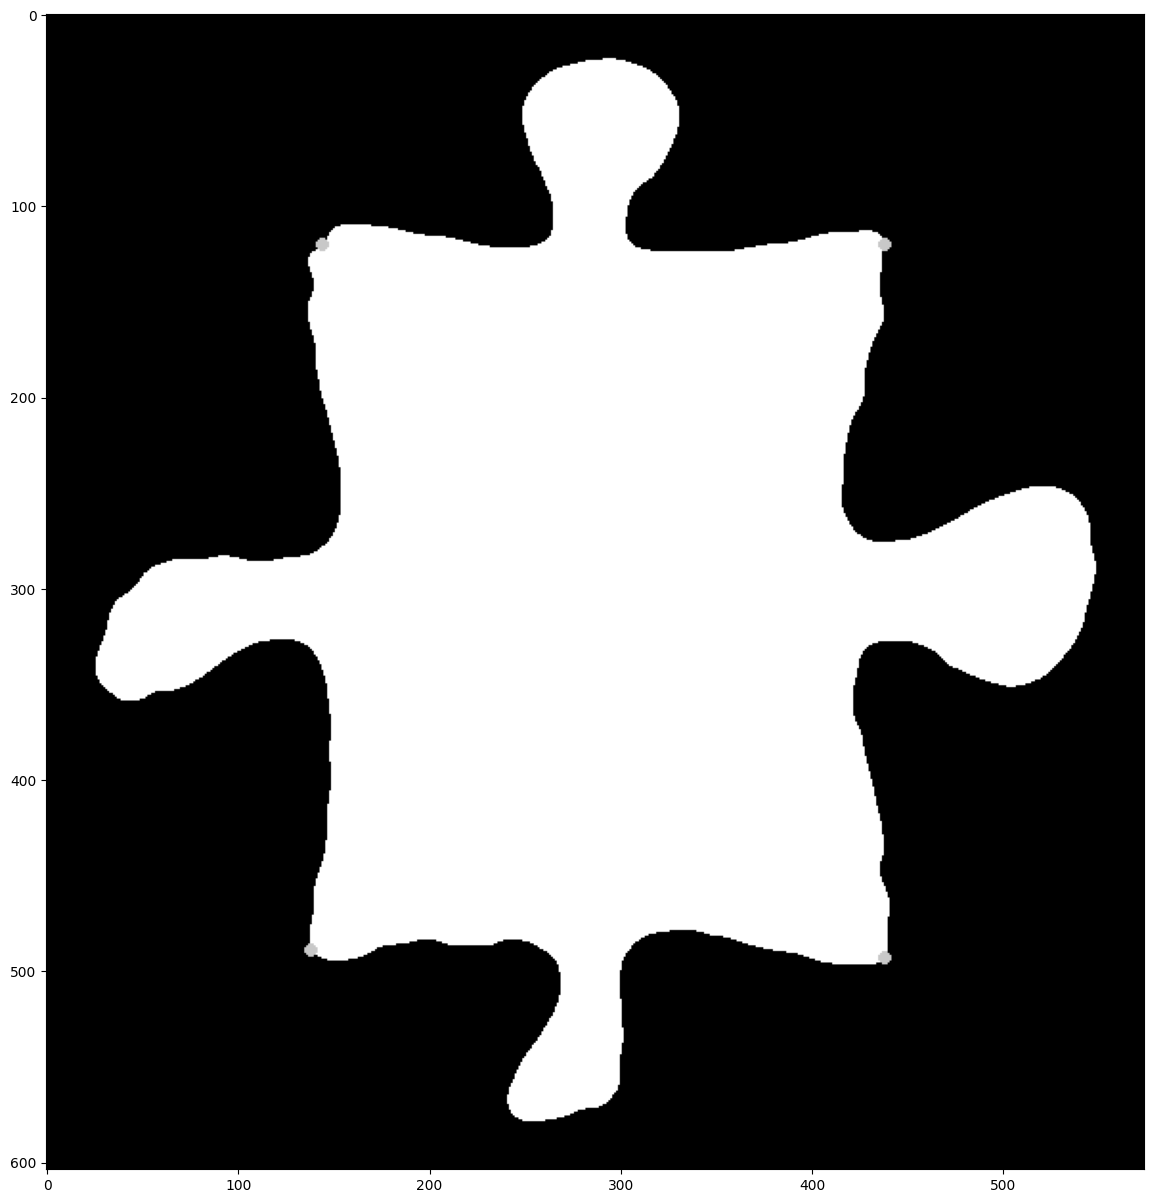

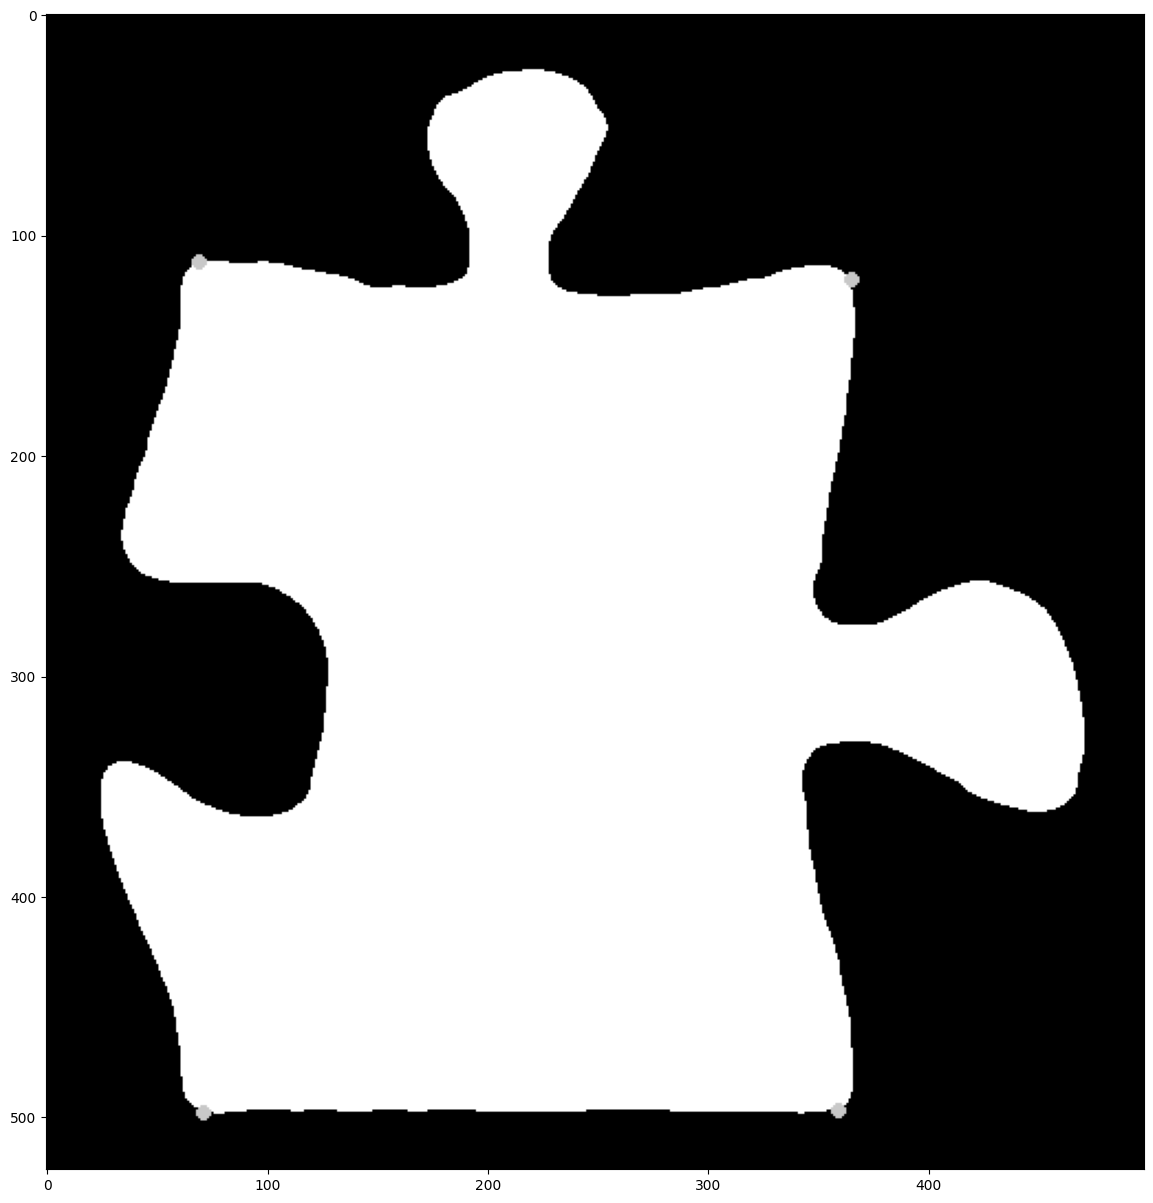

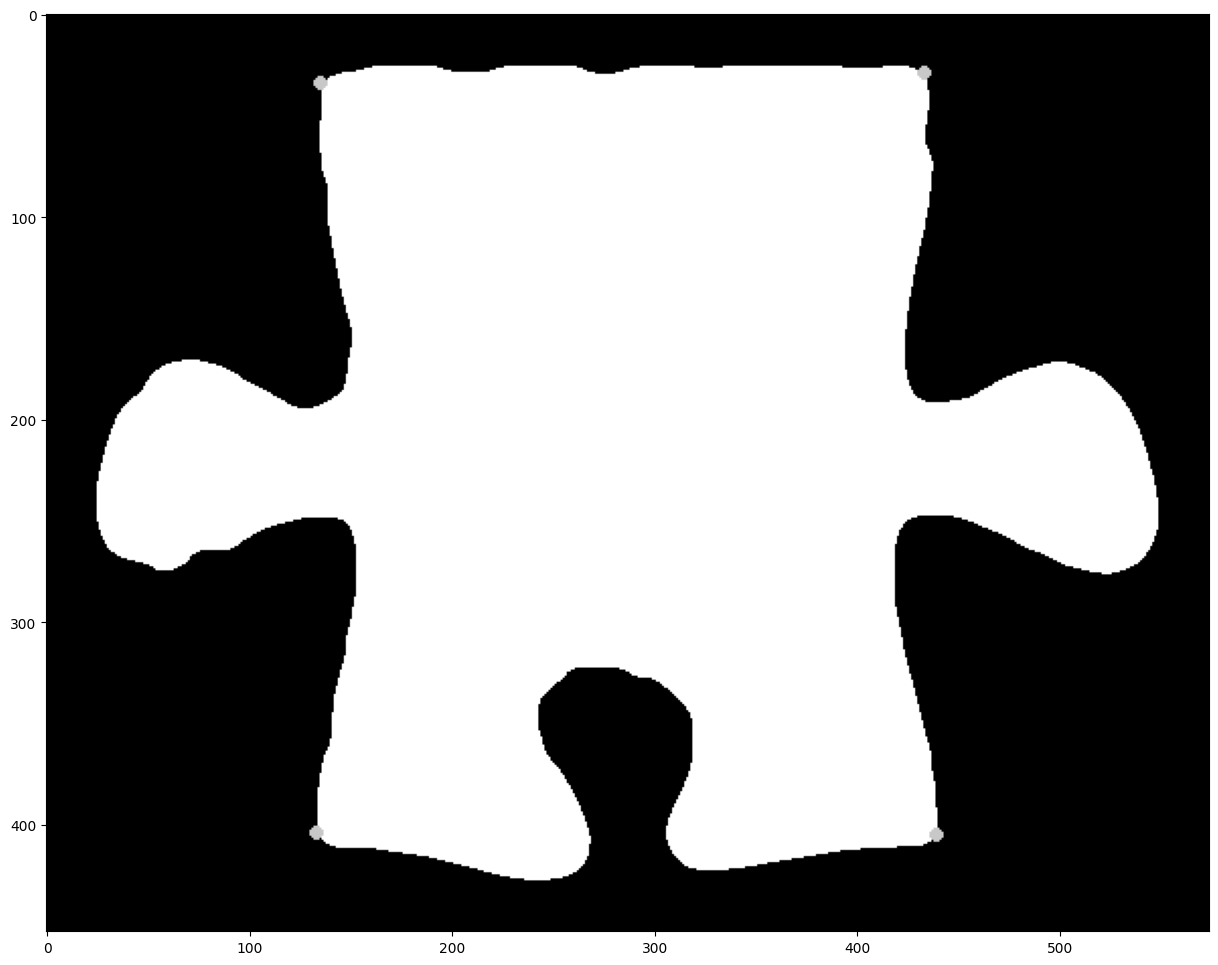

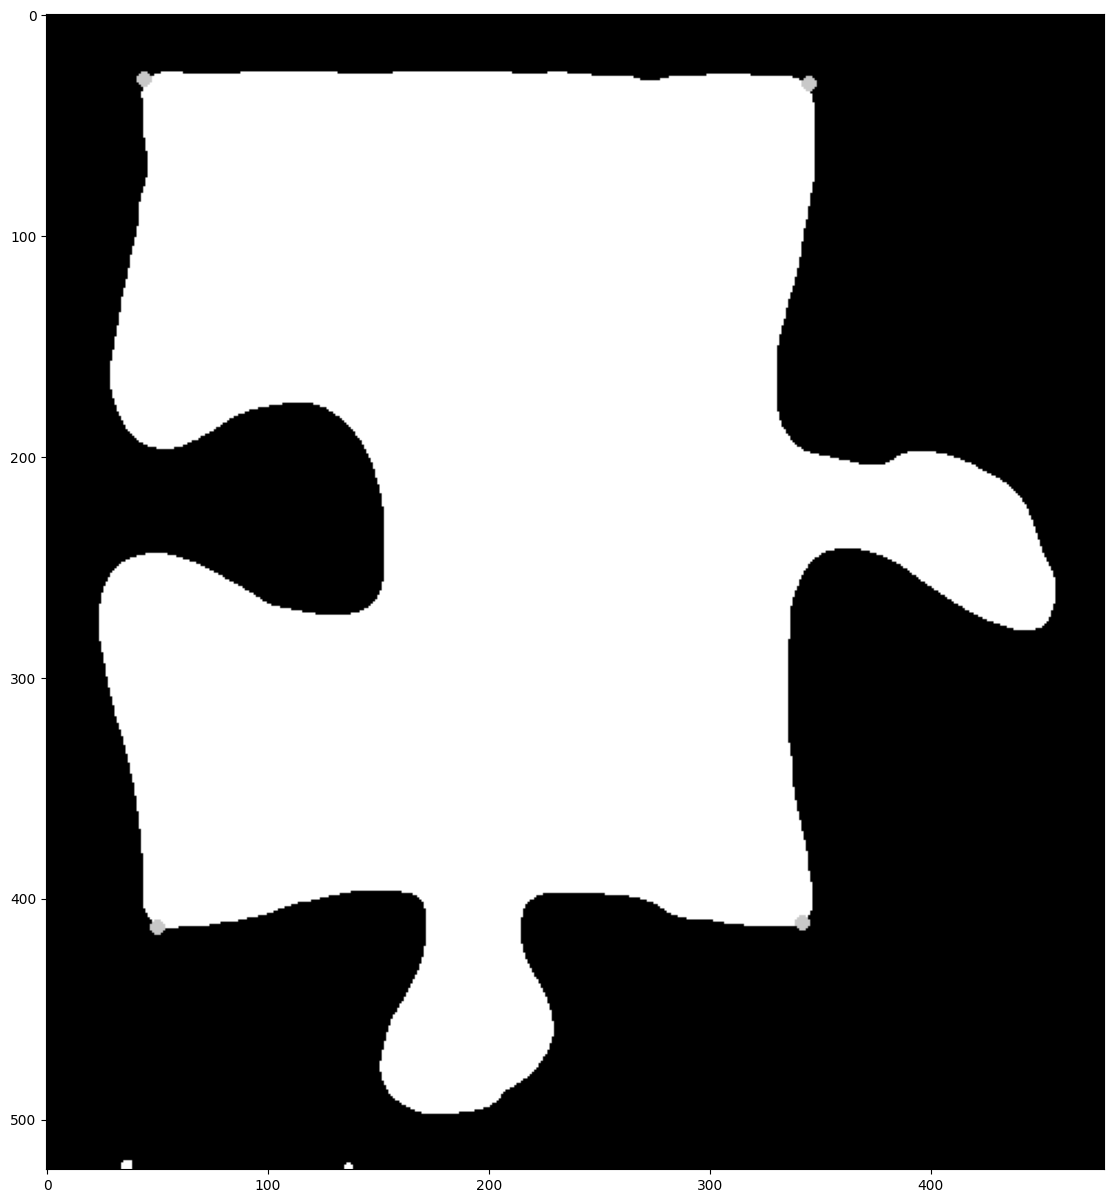

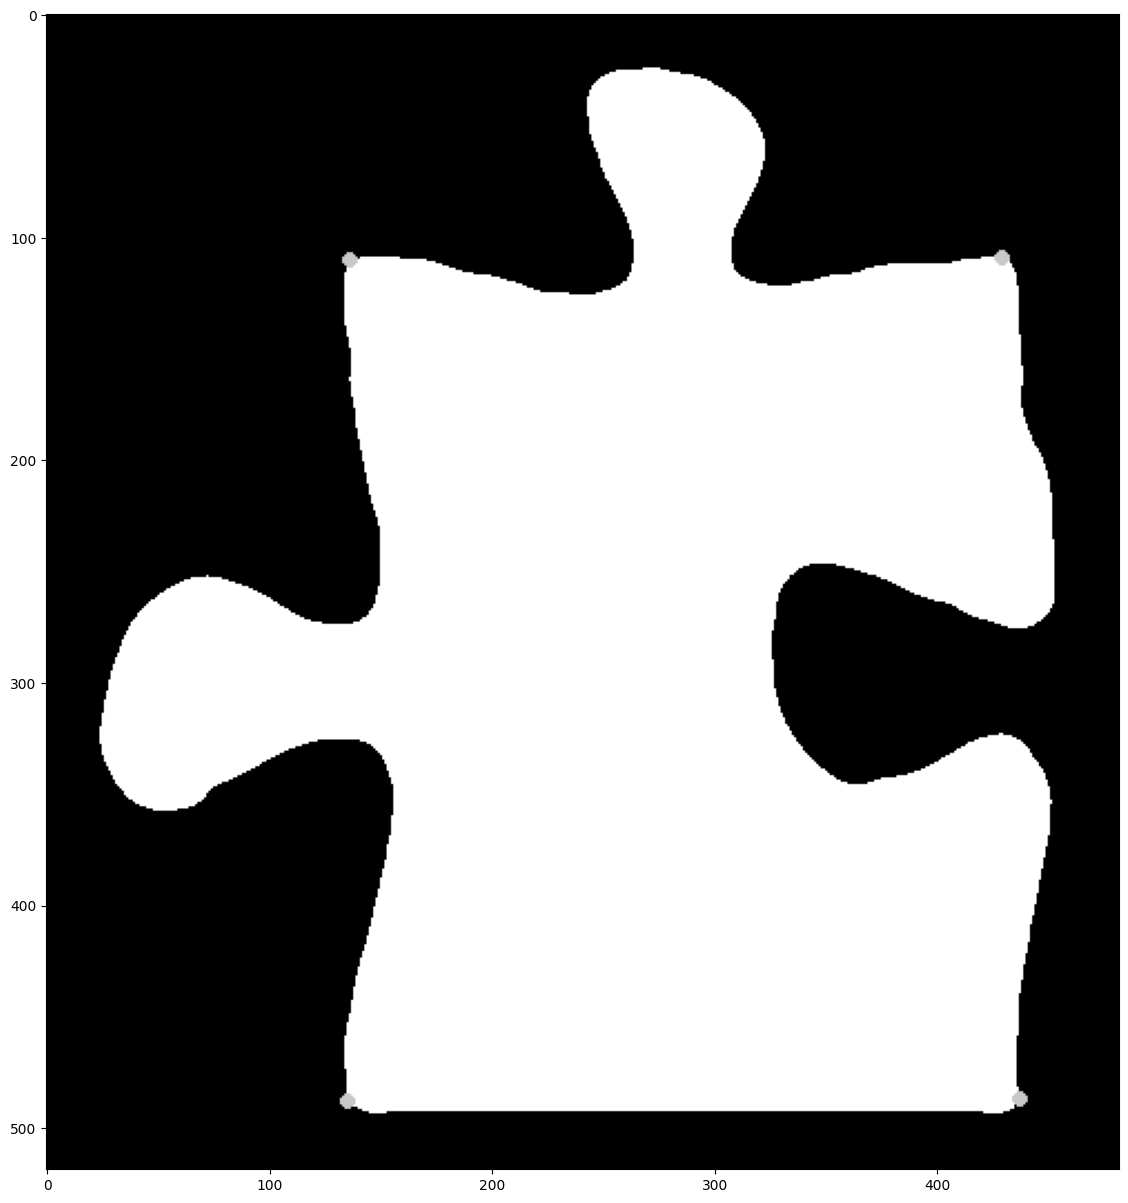

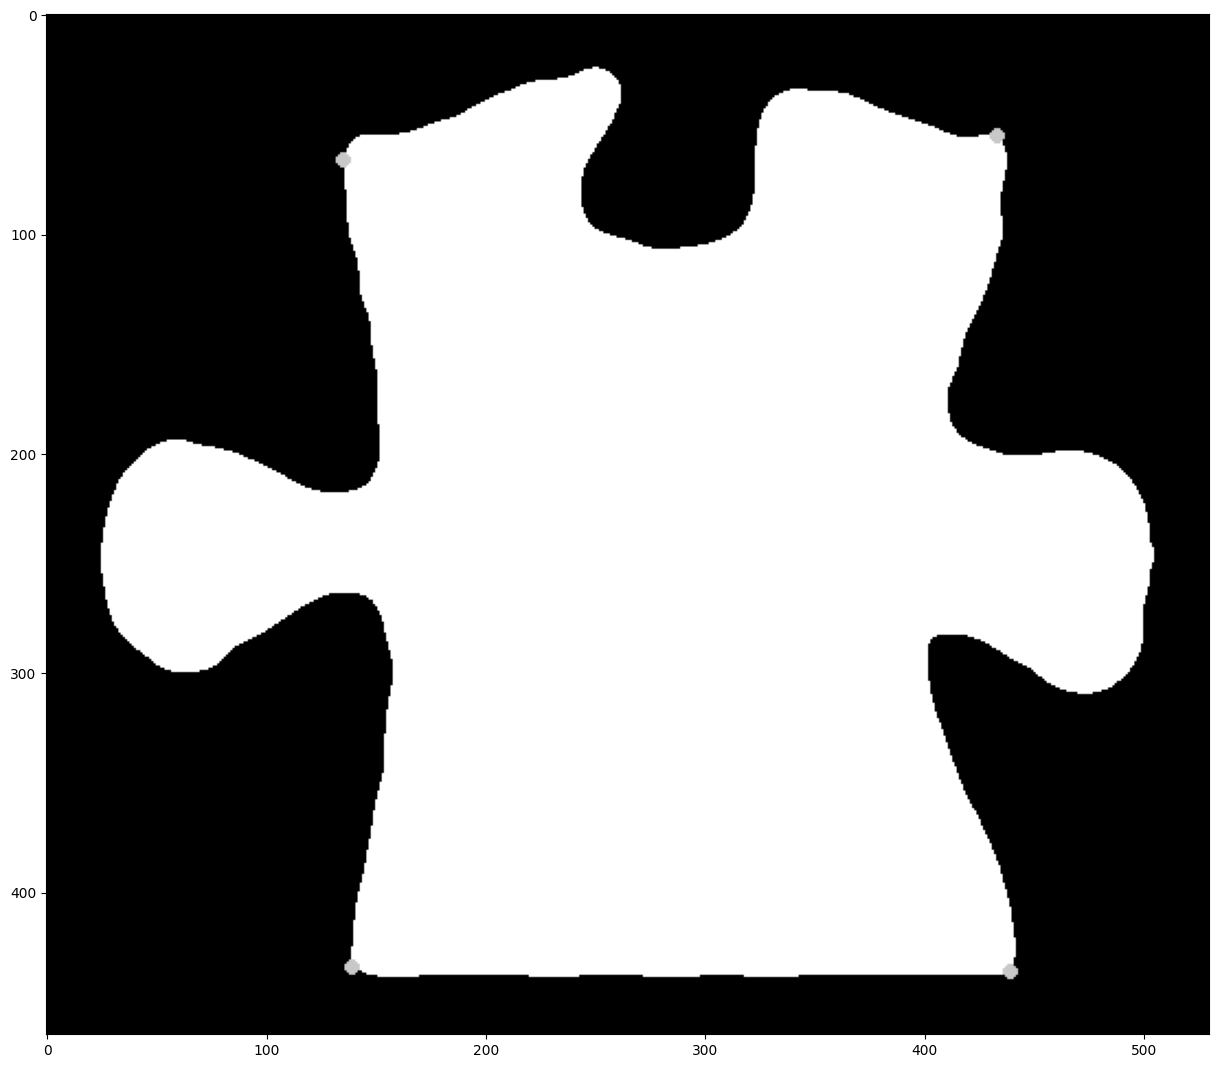

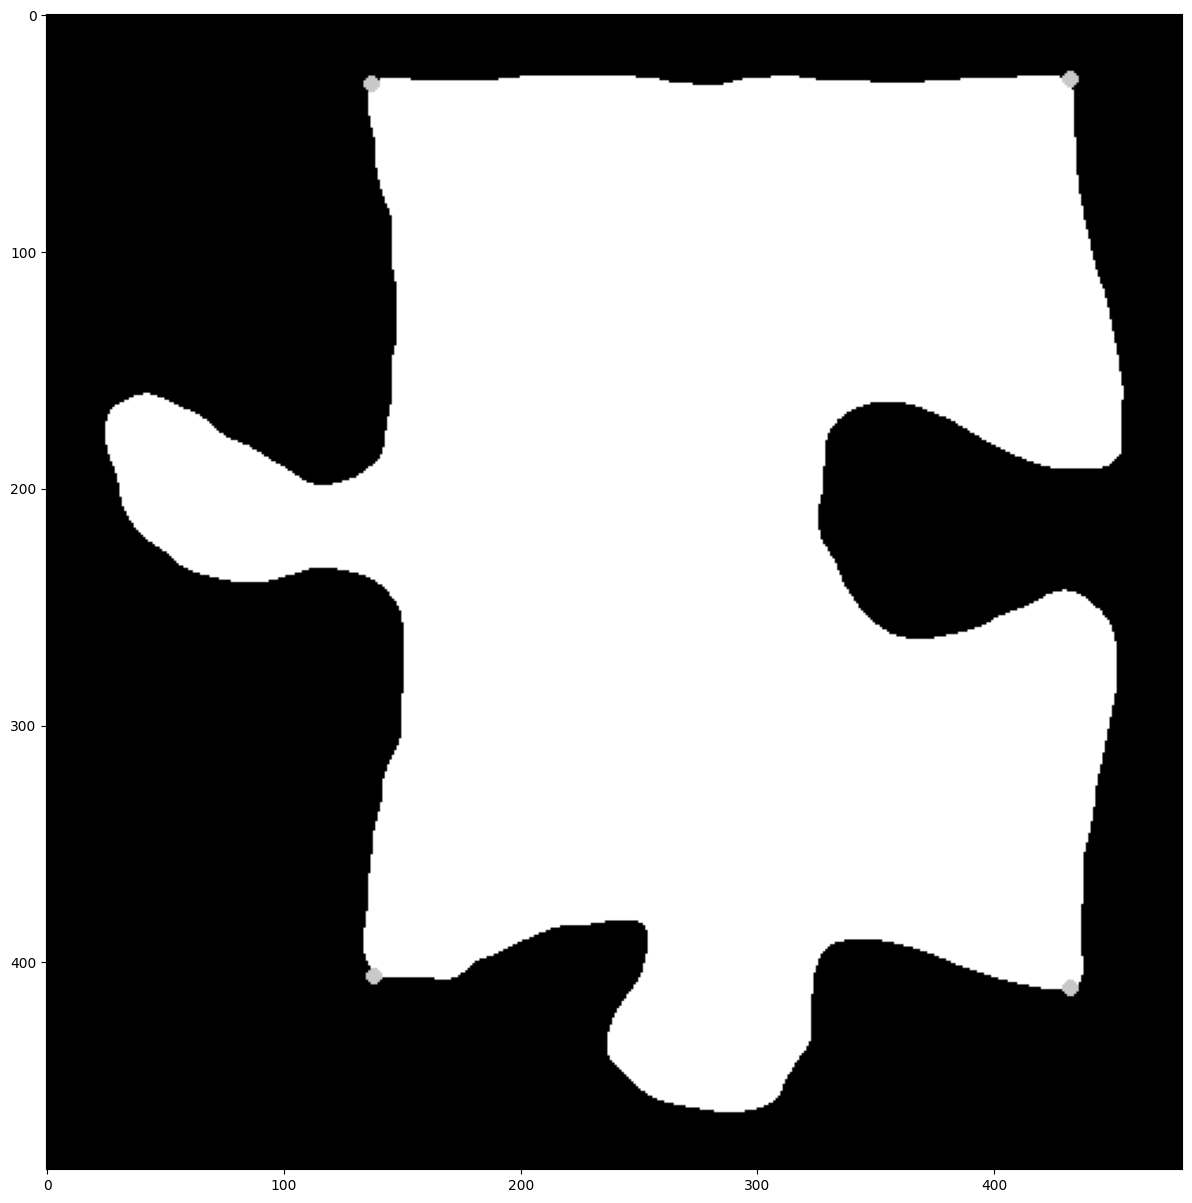

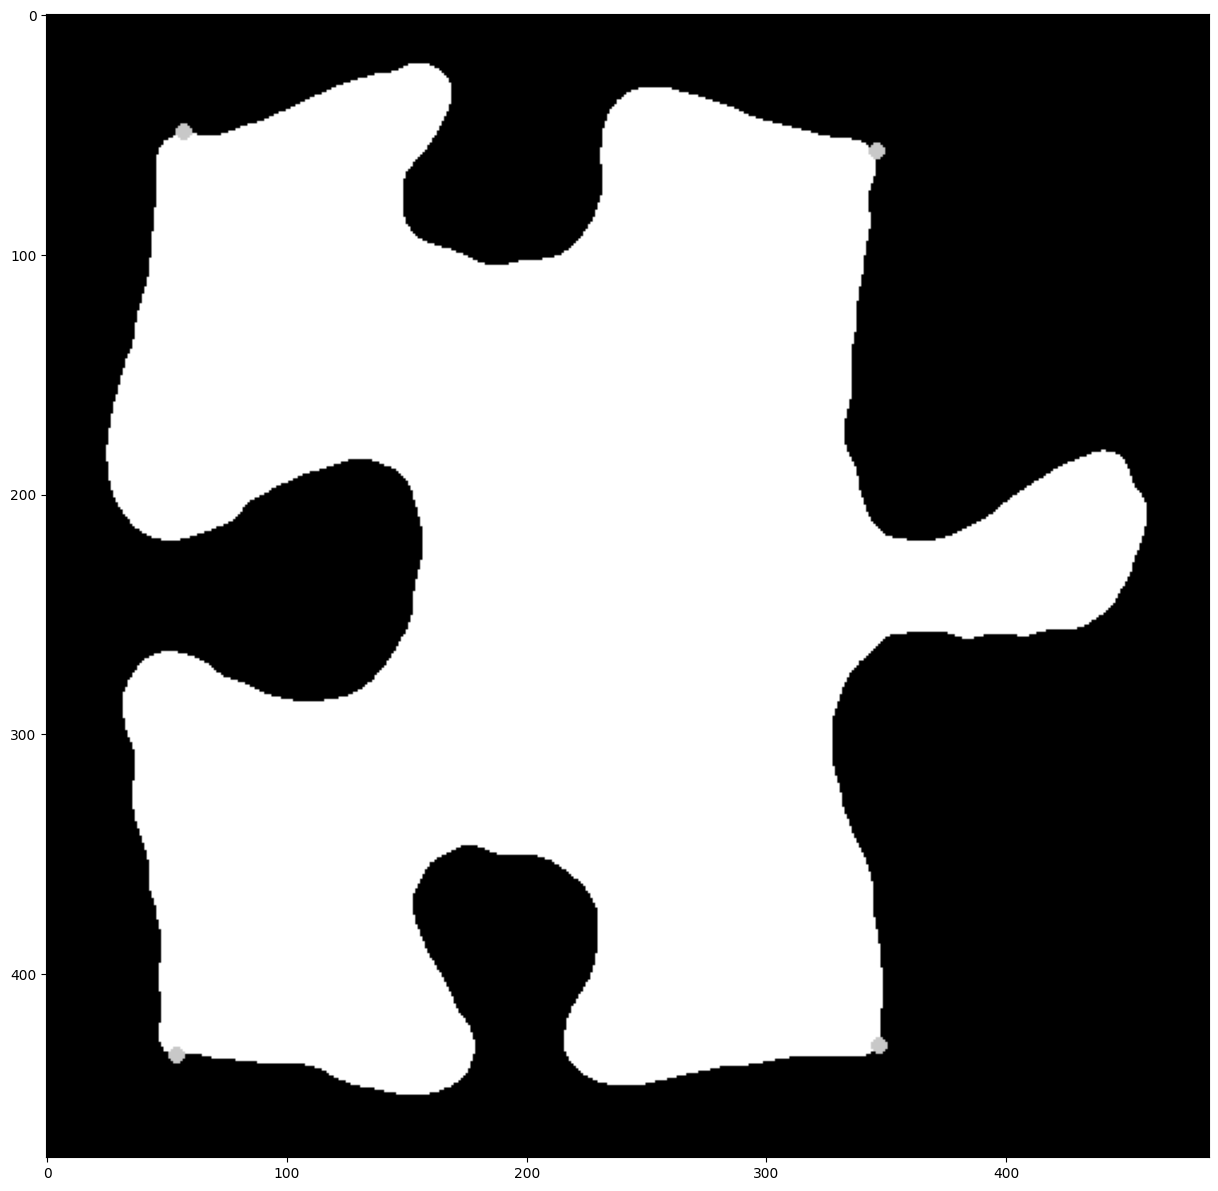

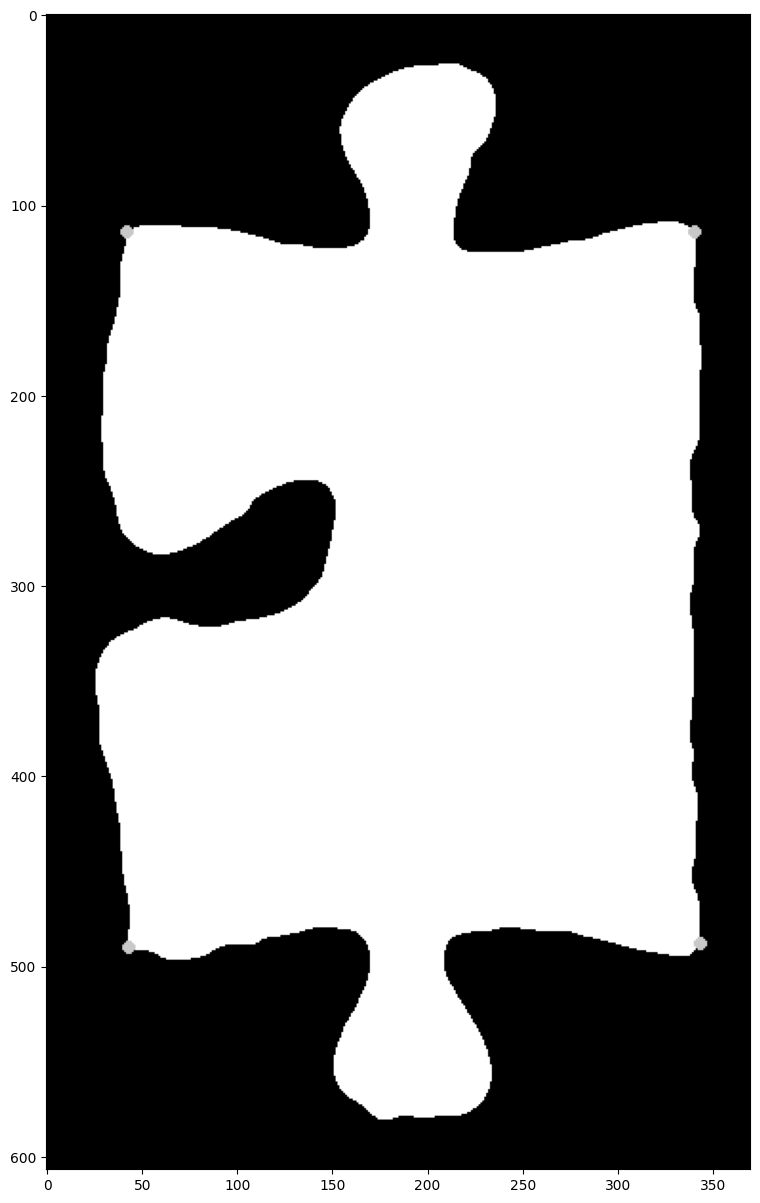

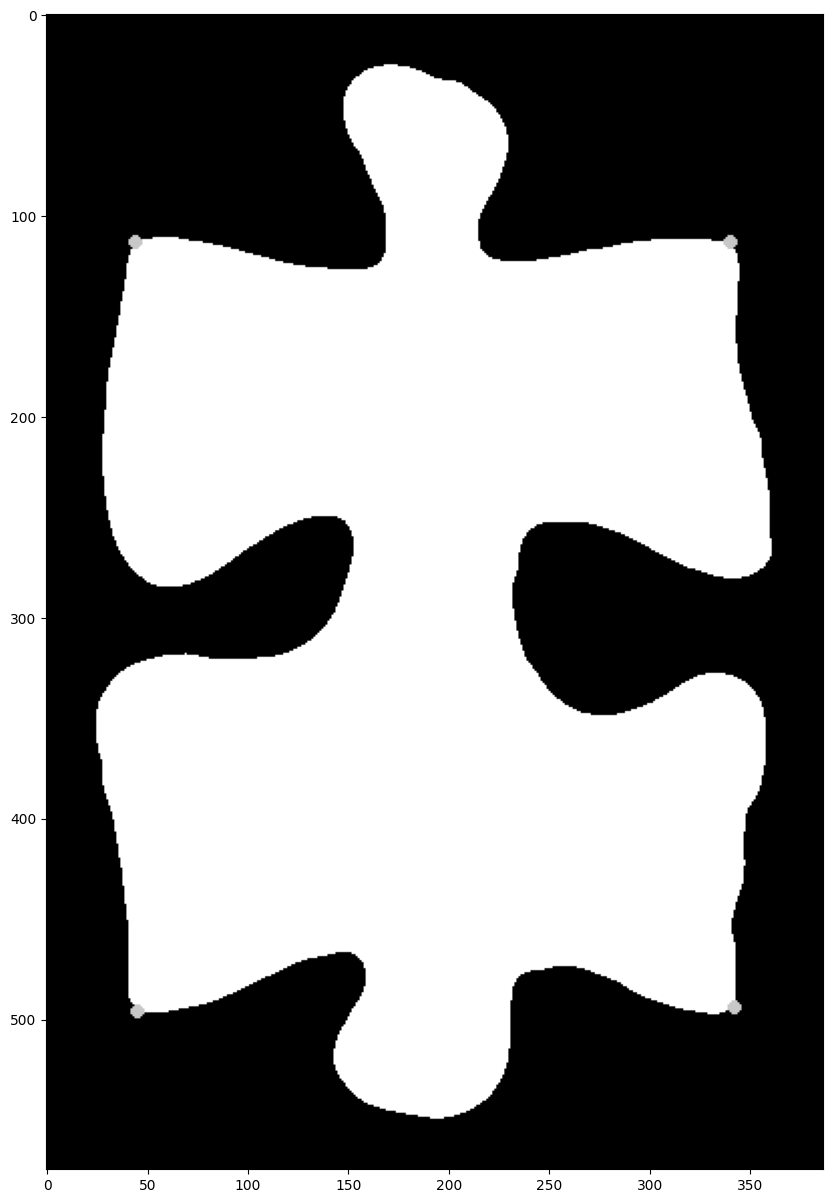

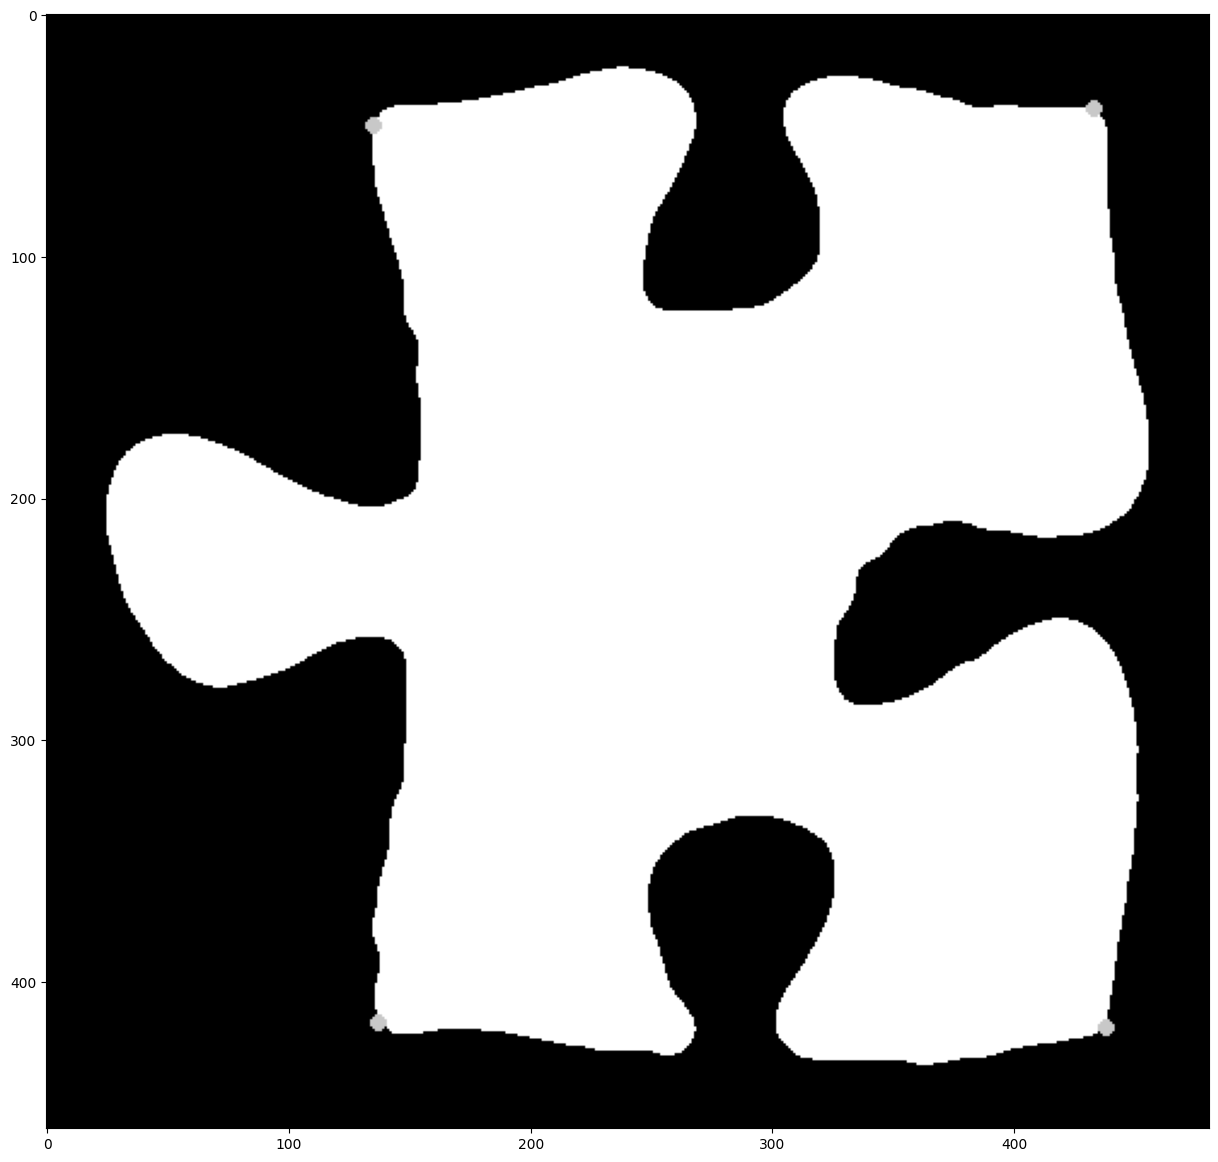

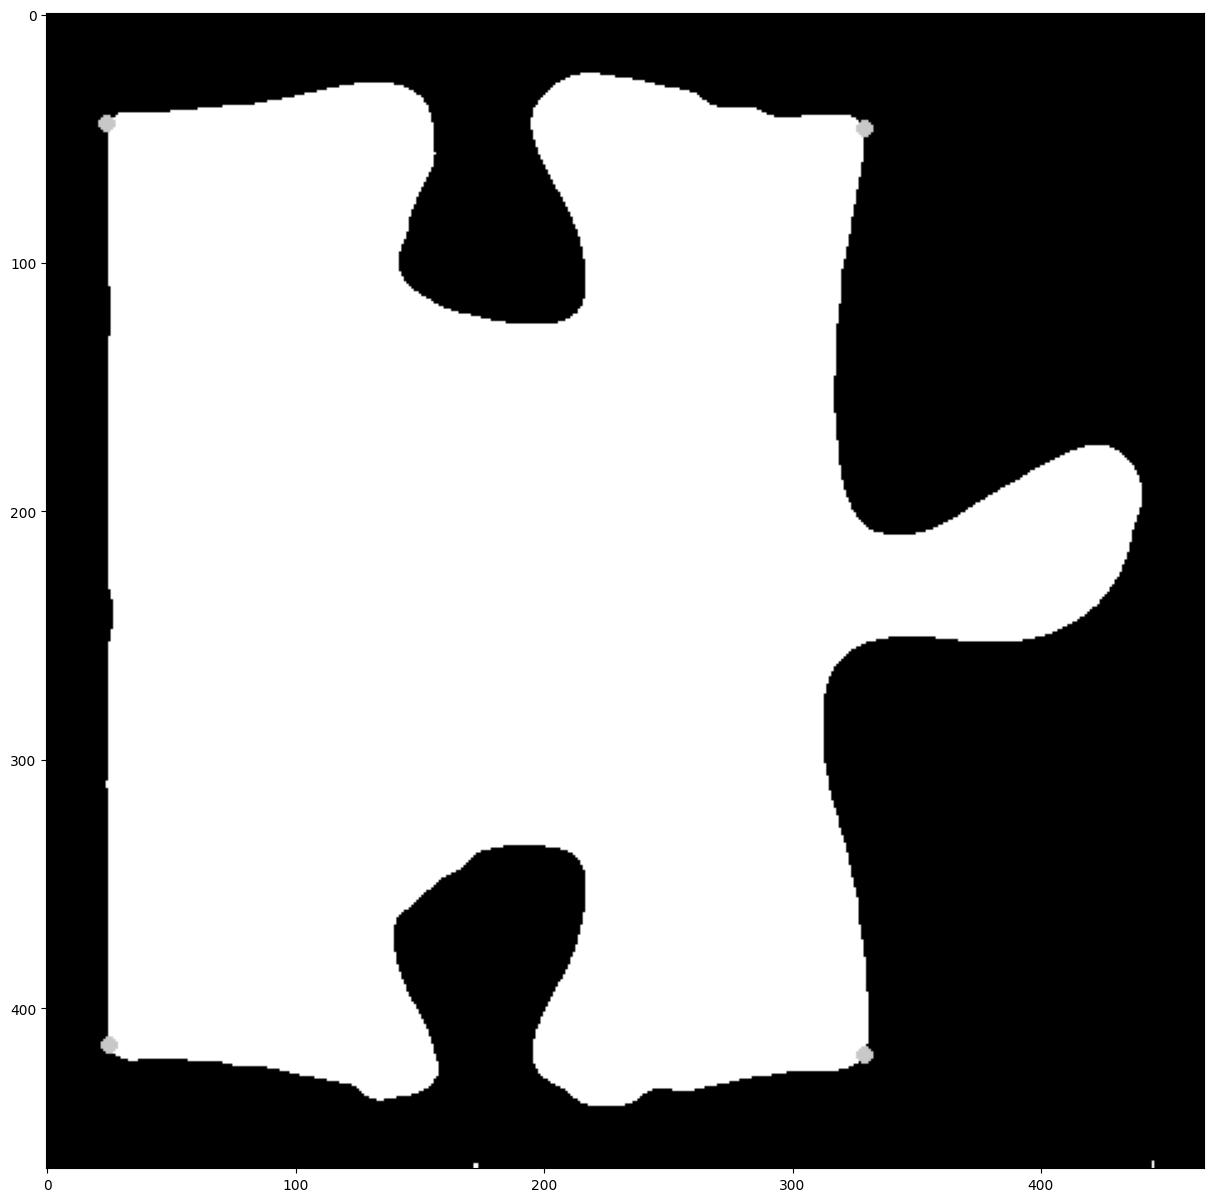

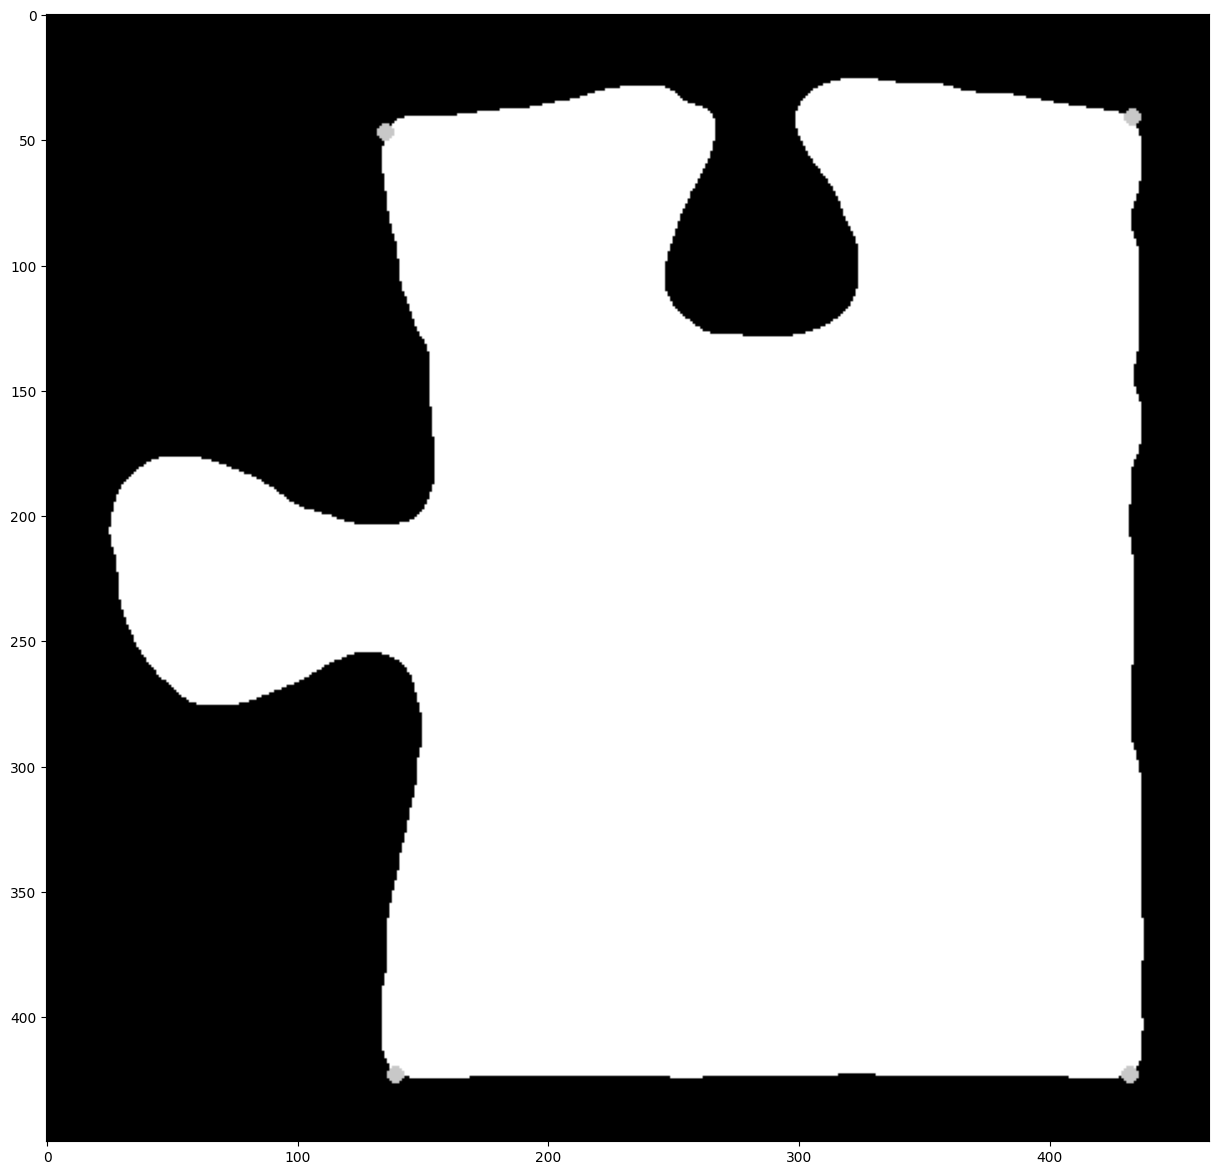

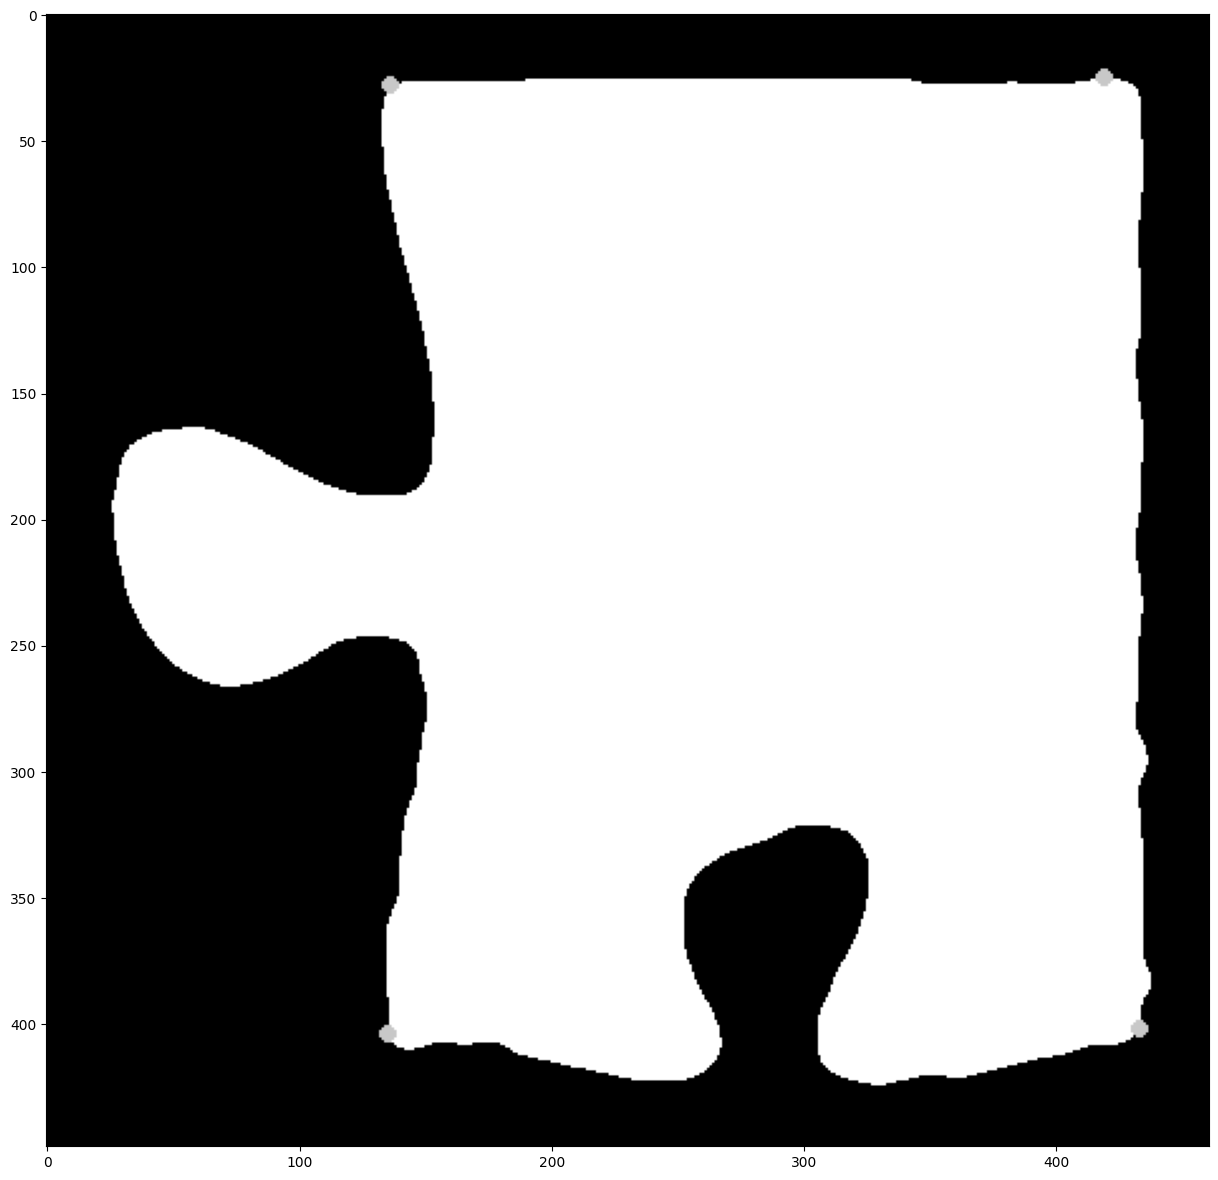

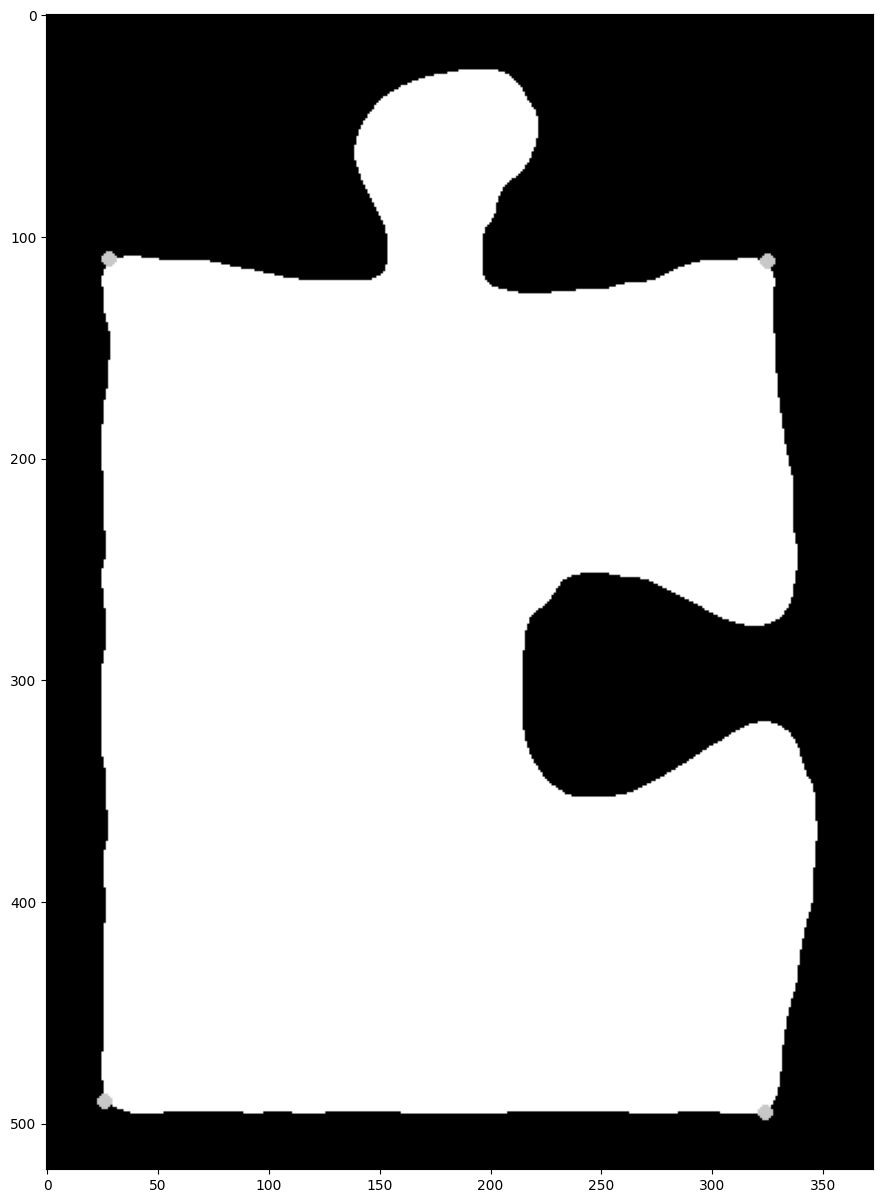

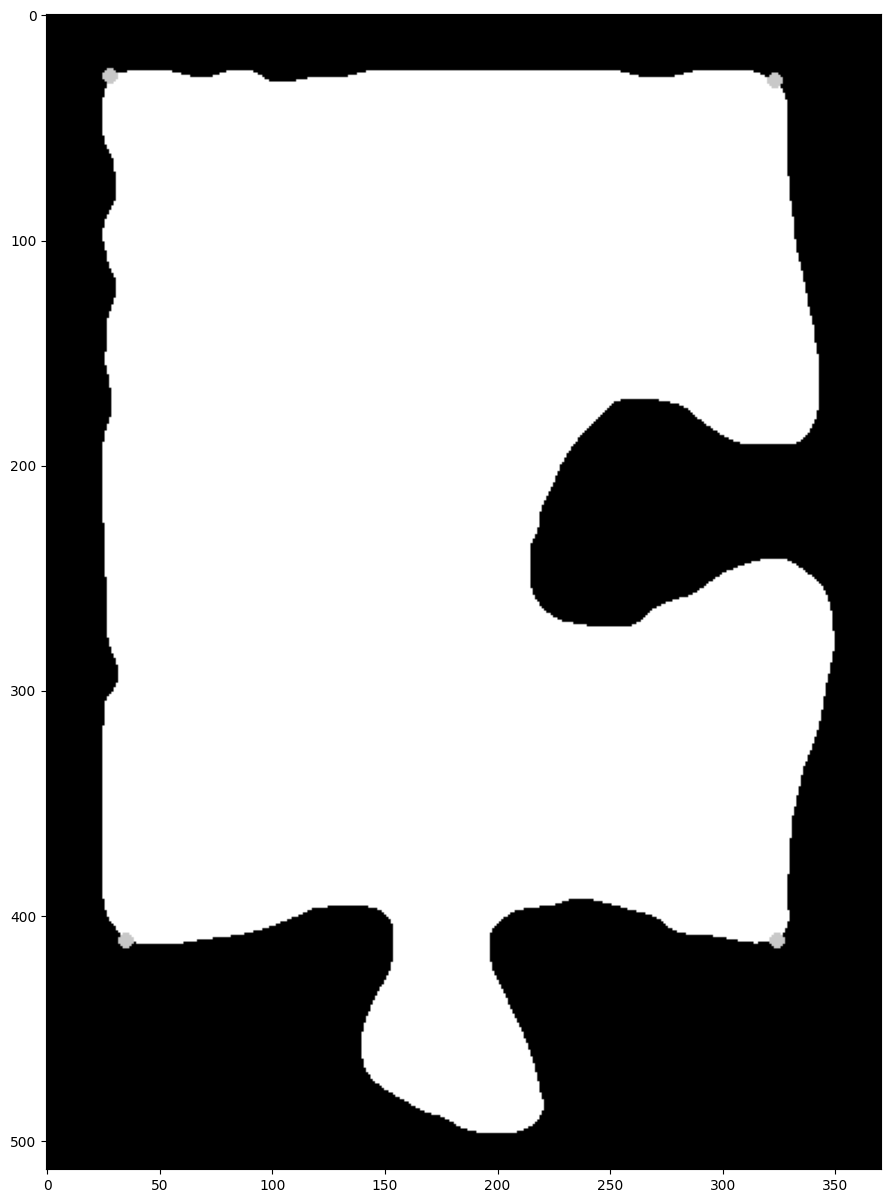

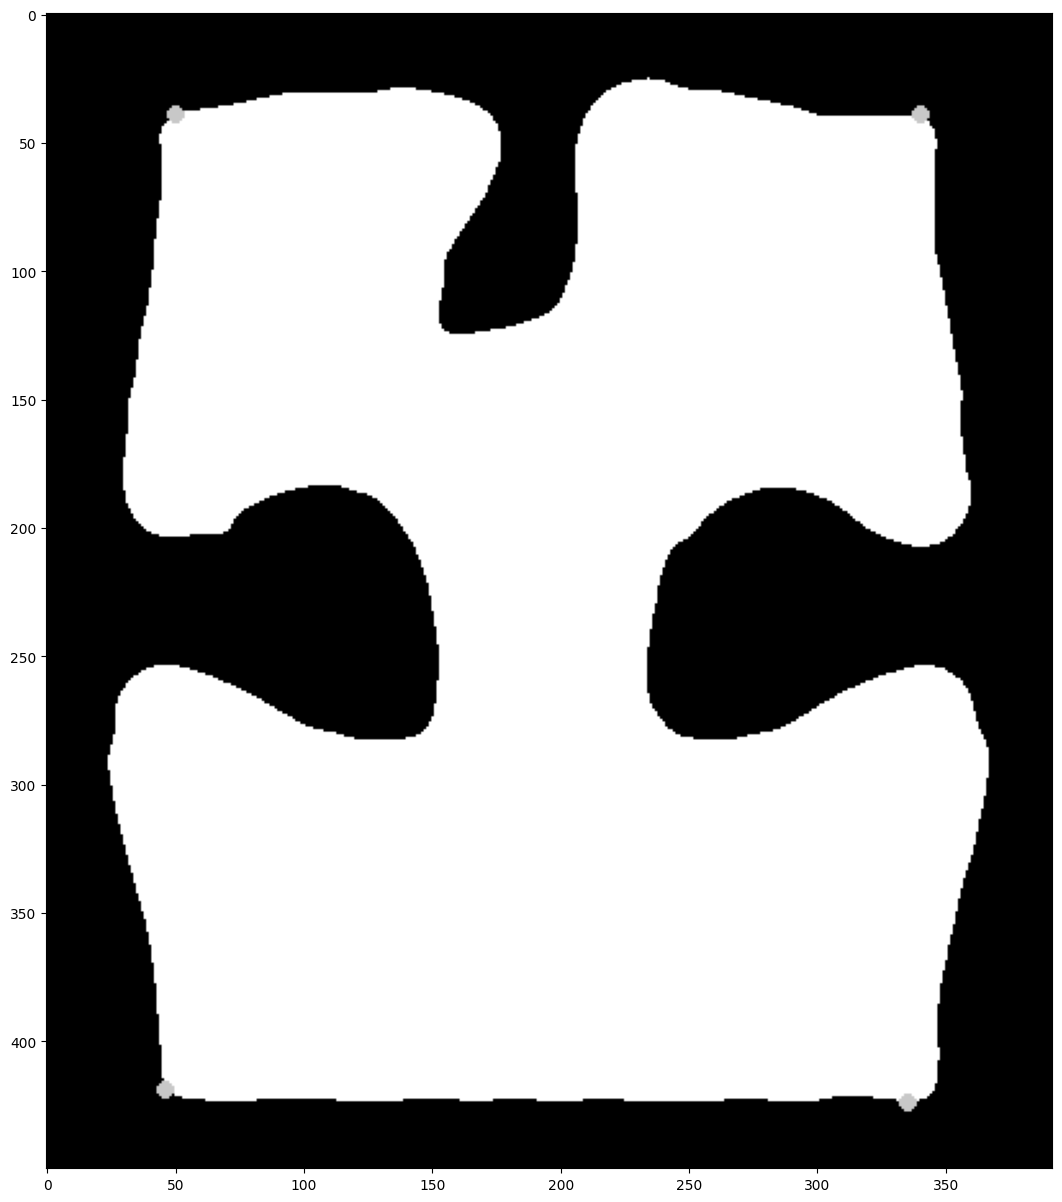

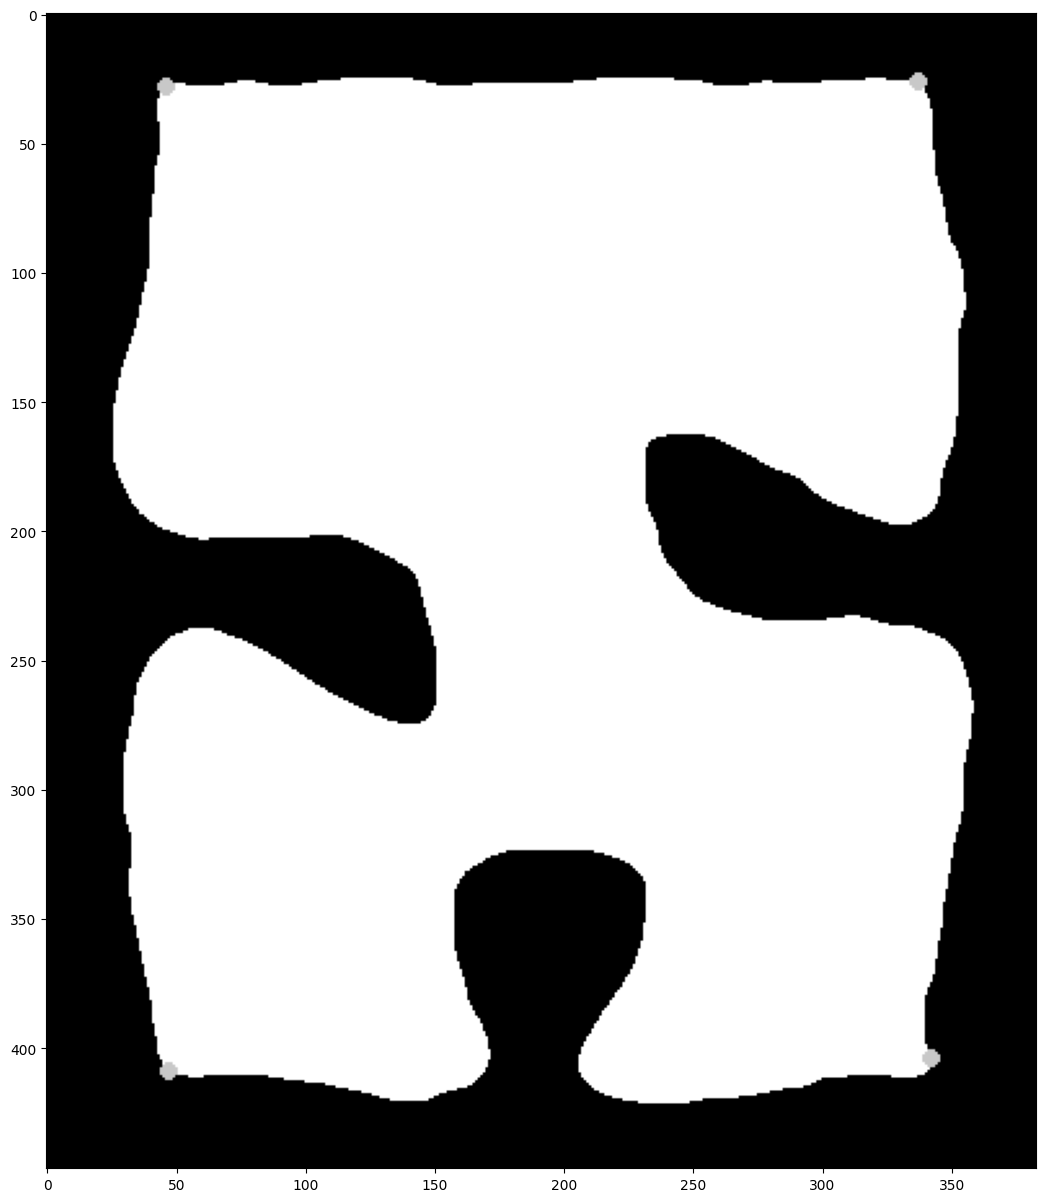

In [20]:
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_bw
    piece_with_corner, corners = find_corners(image)
    (universal_pieces[i]).corners  = corners
    show_gray(piece_with_corner,"")

# Get Edge Images

In [ ]:
def get_slope_intercept(p1, p2, p3):
    slope = 0
    if(p1[1] != p2[1]):
        slope = (p1[0] - p2[0]) / (p1[1] - p2[1])
    else:
        slope = 999
    intercept = p3[1] - slope*p3[0]
    return [slope, intercept]

pieces_side_points = []
colored_pieces_side_points = []

for ind in range(len(universal_pieces)):
    puzzle = (universal_pieces[ind]).corners
    sides = []
    x_avg = sum([j[1] for j in puzzle])/4
    y_avg = sum([j[0] for j in puzzle])/4
    for i in range(4):
        x_mid = (puzzle[i][1] + puzzle[(i+1)%4][1])/2
        y_mid = (puzzle[i][0] + puzzle[(i+1)%4][0])/2
        slope_intercept = get_slope_intercept(puzzle[i], puzzle[(i+1)%4], (x_mid, y_mid))
        inner_line_slope_intercept = [slope_intercept[0], y_avg - slope_intercept[0]*x_avg]
        pieces_corner_drawn = (universal_pieces[ind]).piece_image_bw
        heig, leng = pieces_corner_drawn.shape

        for x in range(leng):
            y = int(slope_intercept[0] * x + slope_intercept[1])
            while 0 <= y < heig:
                if pieces_corner_drawn[y][x] == 255:
                    if(slope_intercept[1] > inner_line_slope_intercept[1]):
                        slope_intercept[1] += 1
                    else:
                        slope_intercept[1] -= 1
                else: break
                y = int(slope_intercept[0] * x + slope_intercept[1])

        if(slope_intercept[0] != 0):
            for y in range(heig):
                x = int(((y-slope_intercept[1]) / slope_intercept[0]))
                while 0 <= x < leng:
                    if pieces_corner_drawn[y][x] == 255:
                        if(slope_intercept[1] > inner_line_slope_intercept[1]):
                            slope_intercept[1] += 1
                        else:
                            slope_intercept[1] -= 1
                    else: break
                    x = int(((y-slope_intercept[1]) / slope_intercept[0]))

        orthogonal_slope = -1/slope_intercept[0] if slope_intercept[0] != 0 else 999
        
        top_left_orthogonal_intercept = puzzle[i][0] - orthogonal_slope*puzzle[i][1]
        top_left_x = (top_left_orthogonal_intercept - slope_intercept[1])/(slope_intercept[0]-orthogonal_slope)
        top_left_y = orthogonal_slope*top_left_x + top_left_orthogonal_intercept
        bottom_left_x = (top_left_orthogonal_intercept - inner_line_slope_intercept[1])/(inner_line_slope_intercept[0]-orthogonal_slope)
        bottom_left_y = orthogonal_slope * bottom_left_x + top_left_orthogonal_intercept 

        top_right_orthogonal_intercept = puzzle[(i+1)%4][0] - orthogonal_slope*puzzle[(i+1)%4][1]
        top_right_x = (top_right_orthogonal_intercept - slope_intercept[1])/(slope_intercept[0]-orthogonal_slope)
        top_right_y = orthogonal_slope * top_right_x + top_right_orthogonal_intercept 
        bottom_right_x = (top_right_orthogonal_intercept - inner_line_slope_intercept[1])/(inner_line_slope_intercept[0]-orthogonal_slope)
        bottom_right_y = orthogonal_slope * bottom_right_x + top_right_orthogonal_intercept 

        #important part (x, y) where x is axis 1 and y is axis 0
        square = [(top_right_x, top_right_y), (bottom_right_x, bottom_right_y), (bottom_left_x, bottom_left_y), (top_left_x, top_left_y)]
        square = [(int(x), int(y)) for x, y in square]
        sides.append(square)
        def draw_line(image, slope, intercept, color=140, thickness=1):
            # Get image dimensions
            length, height= image.shape
            x1 = 0
            y1 = int(slope*x1 + intercept)
            x2 = int(height)
            y2 = int(slope*x2 + intercept)
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
        # draw_line(pieces_corner_drawn[ind], slope_intercept[0], slope_intercept[1])
        # draw_line(pieces_corner_drawn[ind], inner_line_slope_intercept[0], inner_line_slope_intercept[1])
    pieces_side_points.append(sides)
    show_gray(pieces_corner_drawn, "")
                

In [ ]:
b_w_edges = []
for num, x in enumerate(pieces_side_points):
    piece_edges = []
    for y in x:
        len1 = (int) (math.dist(y[0], y[1]))
        len2 = (int) (math.dist(y[1], y[2]))
        transform=[y[3][0], y[3][1], y[2][0], y[2][1], y[1][0], y[1][1], y[0][0], y[0][1]]
        
        img_copy = np.copy((universal_pieces[num]).piece_image_color)
        im = Image.fromarray(img_copy)
        result = im.transform((len2,len1), ImageTransform.QuadTransform(transform))
        img_copy = np.array(result)

        img_copy_bw = np.copy((universal_pieces[num]).piece_image_bw)
        img_copy_bw = img_copy_bw/255
        im = Image.fromarray(np.uint8(cm.gist_earth(img_copy_bw)*255))
        result = im.transform((len2,len1), ImageTransform.QuadTransform(transform))
        img_copy_bw = np.array(result)
        img_copy_bw = cv2.cvtColor(img_copy_bw, cv2.COLOR_BGR2GRAY)

        img_edge = Edges()
        
        height, width = img_copy_bw.shape
        val =0
        for i in range(width):
            j = 0
            while(j != height-1 and img_copy_bw[j][i]==0):
                j +=1
            val +=j
        if val < 1000: 
            print("Flat")
            img_edge.shape = Shape.Flat 
        elif val < 11000: 
            print("Hole")
            img_edge.shape = Shape.Hole
        else: 
            print("Head")
            img_edge.shape = Shape.Head
            #rotate 180
            # img_copy = np.rot90(np.rot90(img_copy))
            # img_copy_bw = np.rot90(np.rot90(img_copy_bw))

        
        img_edge.edge_image_color = img_copy
        img_edge.edge_image_bw = img_copy_bw

        # show_gray(img_edge.edge_image_bw,"")
        show(img_edge.edge_image_color,"")

        piece_edges.append(img_edge)

    (universal_pieces[num]).edges = piece_edges
    




In [ ]:
def edge_array(image):
    completed = False
    arr = []
    image = np.copy(image)
    image = cv2.copyMakeBorder(image,1,0,0,0,cv2.BORDER_CONSTANT, value=0)
    prevx = -1
    xval = 1
    yval = 0
    len, width = image.shape
    while (image[yval+1][xval]==0):
        yval = yval+1
    image[yval][xval] = 100

    direction =0 #0 is up, 1 is right, 2 is down and 3 is left
    move = [[-1,0],[0,1],[1,0],[0,-1]]
    counter = 0
    highesti = -1
    highj = -1
    lowesti = len
    lowj = len
    i = yval
    j = xval
    # print(width)
    while (j!=width-1 and counter<5000):
        counter= counter+1
        index = direction
        top_piece = image[i+move[index%4][0]][j+move[index%4][1]]
        index = index +1
        right_piece = image[i+move[index%4][0]][j+move[index%4][1]]
        if(right_piece==250):
            if(top_piece==250):
                direction = direction-1
            else:
                if(i>highesti):
                    highesti = i
                    highj = j
                if(i<lowesti):
                    lowesti = i
                    lowj = j
                prevx = i
                i = i+move[direction%4][0]
                j = j+move[direction%4][1]
                arr.append((prevx-i))
                image[i][j]=100
        else:
            prevx = i
            direction = direction+1
            i = i+move[direction%4][0]
            j = j+move[direction%4][1]
            arr.append((prevx-i))
            image[i][j]=100
    
    #image[highesti][highj] = 150
    # image[lowesti][lowj] = 150

    # print(counter)    

    # show_gray(image, "")
    return arr, [highesti, highj] , [lowesti, lowj]

In [ ]:
max = 0
min_width = 1000000
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).edges
    for j in range(len(image)):
        if((image[j]).shape != Shape.Flat):
            _, thickness = ((image[j]).edge_image_bw).shape
            if(thickness<min_width):
                min_width = thickness
            edge = (image[j]).edge_image_bw
            arr, high, low = edge_array(edge)
            (image[j]).high = high
            (image[j]).low = low
            width = high[0] - low[0]
            # print(width)
            (image[j]).arr = arr
            if(width>max):
                max = width
            # print(edge)
            # show_gray(edge, "")
print(max)
print(min_width)
pad = 15
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).edges
    for j in range(len(image)):
        _, edge_width = ((image[j]).edge_image_bw).shape
        start_width = int((edge_width-min_width)/2)
        end_width = edge_width-(edge_width-min_width-start_width)
        if((image[j]).shape == Shape.Head):
            (image[j]).edge_image_bw = ((image[j]).edge_image_bw)[:(max),start_width:end_width]
            (image[j]).edge_image_color = ((image[j]).edge_image_color)[:(max),start_width:end_width]
            # (image[j]).edge_image_bw = cv2.copyMakeBorder((image[j]).edge_image_bw,pad,0,0,0,cv2.BORDER_CONSTANT, value=0)
            # (image[j]).edge_image_color = cv2.copyMakeBorder((image[j]).edge_image_color,pad,0,0,0,cv2.BORDER_CONSTANT, value=0)
            (image[j]).edge_image_bw = np.rot90(np.rot90((image[j]).edge_image_bw))
            (image[j]).edge_image_color = np.rot90(np.rot90((image[j]).edge_image_color))
        if((image[j]).shape == Shape.Hole):
            stop = (image[j]).high[0]
            padding = max - stop
            (image[j]).edge_image_bw = ((image[j]).edge_image_bw)[:(stop),start_width:end_width]
            (image[j]).edge_image_color = ((image[j]).edge_image_color)[:(stop),start_width:end_width]
            (image[j]).edge_image_bw = cv2.copyMakeBorder((image[j]).edge_image_bw,padding,0,0,0,cv2.BORDER_CONSTANT, value=0)
            (image[j]).edge_image_color = cv2.copyMakeBorder((image[j]).edge_image_color,padding,0,0,0,cv2.BORDER_CONSTANT, value=0)
            
            


for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).edges
    for j in range(len(image)):
        if((image[j]).shape != Shape.Flat):
            edge = (image[j]).edge_image_color
            show_gray(edge, "")
            print(edge.shape)

In [ ]:
show(universal_pieces[1].edges[0].edge_image_color,"")
show(universal_pieces[3].edges[2].edge_image_color,"")
show(cv2.bitwise_or(universal_pieces[3].edges[2].edge_image_color,universal_pieces[1].edges[0].edge_image_color),"")

In [ ]:
hole_arr = []
head_arr = []
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).edges
    for j in range(len(image)):
        edge  = (image[j]).edge_image_color
        if((image[j]).shape == Shape.Hole):
            hole_arr.append(edge)
        elif((image[j]).shape == Shape.Head):
            head_arr.append(edge)

for i in hole_arr:
    for j in head_arr:
        show(cv2.bitwise_xor(j,i),"")